# Import Libraries

All library imports are done in here

In [1]:
# Built-in Library Imports
import os
import requests

from itertools import islice
from time import sleep

# Base Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.base import BaseEstimator
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Sklearn Model Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

# Dotenv Import, allowing the use of .env files.
from dotenv import load_dotenv
load_dotenv()

True

# Variables

All global variables are to be defined in this section.

In [2]:
dataPath = "./datapack"
"""
Defines the folder path where the data is stored. This variable should not be changed as it is
used to locate the data for the project. If there are user-provided data that will be used, these
data must be stored in the folder defined by this variable.

:default: "./datapack"
"""

outputPath = "./output"
"""
Defines the folder path where the output files are stored. This variable should not be changed as it
is used to locate the output files for the project. If there are any output files that will be generated
from the project, these files must be stored in the folder defined by this variable.
"""

defaultTrainData = f"{dataPath}/spotify_songs.csv"
"""
The `defaultTrainData` variable contains the default path to the training data. This is used
when the user does not provide a path to the training data. The path is relative to the root
directory of the project and must remain so.

:default: "./datapath/spotify_songs.csv"
"""

trainData = defaultTrainData
"""
The `trainData` variable contains the path to the training data. This variable is used to store
any user-provided data that will be used for training the model. If the user does not provide
a path to the training data, the `defaultTrainData` variable is used instead.

:default: "./datapath/spotify_songs.csv"
"""

indexes = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]
"""
Contains all the indexes that are used for the audio features. These indexes are the `x`
values for the model.
"""

audioFeatures = ['track_popularity'] + indexes
"""
The `audioFeatures` list contains all the audio features that are used for training the model.
This includes the entire `indexes` list while the `track_popularity` is added to the list but
is not included in the `indexes` list. This is because the `track_popularity` is the `y` value
for the model.
"""

undersampling: str = "test"
"""
Defines what kind of undersampling to use. The `undersampling` variable can be set to either
`singular` or `multiple`. If the variable is set to `singular`, the undersampling method will
only use the standard undersampling while using `multiple` or `multi` will use the multiple
fractional undersampling.

If the value is set to `test`, the data will be copied twice to include both `singular` and
`multiple` undersampling methods. This is used for testing purposes.
"""

saveOutput: bool = True
"""
Saves the output of the model to a file. If the `saveOutput` variable is set to `True`, the
output of the model will be saved to a file in the `outputPath` folder. If the variable is set
to `False`, the output will not be saved to a file.
"""

saveInput: bool = False
"""
Saves the dataframes to a file. If the `saveInput` variable is set to `True`, the dataframes
used for training the model will be saved to a file in the `outputPath` folder. If the variable
is set to `False`, the dataframes will not be saved to a file.
"""

dropZeroes: bool = False
"""
Drops all rows that contain a zero value in the `track_popularity` column.

Can be used to remove all rows that contain a zero value in the `track_popularity` column by
providing a conditional statement with this variable as the condition.
"""

'\nDrops all rows that contain a zero value in the `track_popularity` column.\n\nCan be used to remove all rows that contain a zero value in the `track_popularity` column by\nproviding a conditional statement with this variable as the condition.\n'

# Functions

All functions to define are done in this section. This section is divided into two categories:

- [API Functions](#api-functions)
- [Model Functions](#model-functions)
- [Project Functions](#project-functions)

## API Functions

All API related functions are created in this category, such as the `getToken` function where it fetches the user's access token by feeding it the `CLIENT_ID` and `CLIENT_SECRET` tokens.

In [3]:
def getToken() -> str:
    """
    Fetches the user's `ACCESS_TOKEN` by sending a POST request to Spotify's API.
    Access token is required to make requests to Spotify's API.
    To be able to get the token, you need to have a `CLIENT_ID` and `CLIENT_SECRET`
    which can be obtained by creating a Spotify Developer account, which will then be
    put in a `.env` file in the root directory of the project.
    
    :return str: The access token of the user.
    :raises Exception: If the request does not return a status code of 200.
    """

    url = "https://accounts.spotify.com/api/token"
    header = {"Content-type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "client_credentials",
        "client_id": os.getenv("CLIENT_ID"),
        "client_secret": os.getenv("CLIENT_SECRET")
    }

	# Send request to get token
    res = requests.post(
        url,
        headers = header,
        data = data
    )

    if res.status_code == 429:
        print(res)
        raise Exception(f"getToken: Rate Limit Exceeded, try again in {res.headers.get('Retry-After', 1)} seconds")
    # if request does not return 200, raise exception
    elif res.status_code != 200:
        raise Exception("getToken: ", res.text)

    # Example Output: 'BQCq8oiJHxi.....iv_5sAuoF1YwhQADyc'
    return res.json()['access_token']

# ==================================================================================================== #

def getAudioFeatures(trackID: str) -> dict:
    """
    Fetches the audio features of a track by sending a GET request to Spotify's API.
    
    The audio features include the following:
    - **`acousticness`** [0.0 - 1.0] -      A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    - **`analysis_url`** [string] -         An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.
    - **`danceability`** [0.0 - 1.0] -      Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
    - **`duration_ms`** [int] -             The duration of the track in milliseconds.
    - **`energy`** [0.0 - 1.0] -            Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
    - **`id`** [string] -                   The Spotify ID for the track.
    - **`instrumentalness`** [0.0 - 1.0] -  Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
    - **`key`** [int] -                     The key the track is in. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
    - **`liveness`** [0.0 - 1.0] -          Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
    - **`loudness`** [-60.0 - 0.0] -        The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
    - **`mode`** [int] -                    Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
    - **`speechiness`** [0.0 - 1.0] -       Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.
    - **`tempo`** [float] -                 The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    - **`time_signature`** [int] -          An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
    - **`track_href`** [string] -           A link to the Web API endpoint providing full details of the track.
    - **`type`** [string] -                 The object type: “audio_features”
    - **`uri`** [string] -                  The Spotify URI for the track.
    - **`valence`** [0.0 - 1.0] -           A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    
    :param trackID: The Spotify ID for the track. (Example: "06AKEBrKUckW0KREUWRnvT")
    :type trackID: str
    
    :return dict: The audio features of the track.
    """
    url = "https://api.spotify.com/v1/audio-features/" + trackID
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )

    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getAF: {res.json()["error"]["message"]}")
    
    return res.json()

# ==================================================================================================== #

def getPopularity(trackID: str, multiple: bool = False) -> int:
    """
    Fetches the popularity of a track by sending a GET request to Spotify's API.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"`)
    :type trackID: str
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return int | dict: The popularity of the track. If `multiple` is set to `True`, a dictionary with the track IDs as the keys and the popularity as the values will be returned.
    """
    
    url = f"https://api.spotify.com/v1/tracks{"?ids=" if multiple else "/"}{trackID}"
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )
    
    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getPopularity: {res.json()["error"]["message"]}")
    
    if multiple:
        toRet = {}
        for track in res.json()['tracks']:
            toRet[track['id']] = track['popularity']
        return toRet
    else:
        return res.json()['popularity']

# ==================================================================================================== #

def getName(trackID: str, withArtist: bool = False, multiple: bool = False) -> str:
    """
    Fetches the name of a track by sending a GET request to Spotify's API.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"` => `"Kekkon Koushinkyoku"`)
    :type trackID: str
    
    :param withArtist: Whether to include the artist of the track in the output. (Default: `False`)
    :type withArtist: bool
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return str: The name of the track. If `withArtist` is set to `True`, the name of the track and the artist will be included in the output. And if `multiple` is set to `True`, a dictionary with the track IDs as the keys and the names as the values will be returned.
    """
    
    url = f"https://api.spotify.com/v1/tracks{"?ids=" if multiple else "/"}{trackID}"
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )
    
    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getName: {res.json()["error"]["message"]}")
    
    if multiple:
        toRet = {}
        for track in res.json()['tracks']:
            toRet[track['id']] = track['name'] + (" (" + track['artists'][0]['name'] + ")" if withArtist else "")
        return toRet
    else:
        return res.json()['name'] + (" (" + res.json()['artists'][0]['name'] + ")" if withArtist else "")

# ==================================================================================================== #

def getSongData(trackID: str, withName: bool = False, asDataFrame: bool = False, multiple: bool = False) -> dict | list | pd.DataFrame:
    """
    Fetches the audio features and popularity of a track by sending a GET request to Spotify's API.
    
    If `withName` is set to `True`, the name of the track and the artist will be included in the
    output, allowing for easier identification of the track. The format of the output will be a list
    with the first element being the audio features and popularity of the track, and the second element
    being the name of the track and the artist.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"` => `"Kekkon Koushinkyoku"`)
    :type trackID: str
    
    :param withName: Whether to include the name of the track and the artist in the output. (Default: `False`)
    :type withName: bool
    
    :param asDataFrame: Whether to return the data as a `DataFrame` or not. (Defaults: `False`)
    :type asDataFrame: bool
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return dict | list | pd.DataFrame: The audio features and popularity of the track. If `withName` is set to `True`, the name of the track and the artist will be included in the output.
    """
    songData = None
    if multiple:
        for id in trackID.split(","):
            songData = getAudioFeatures(id)
            sleep(1)
    else:
        songData = getAudioFeatures(trackID)
    
    songData['track_popularity'] = getPopularity(trackID, multiple = multiple)
    
    needed = ["track_popularity"] + indexes
    name = None
    
    if (withName):
        name = getName(trackID, withArtist = True, multiple = multiple)
    
    for key in list(songData.keys()):
        if key not in needed:
            del songData[key]
    
    if (asDataFrame):
        songData = pd.DataFrame(songData, index = [0])
    
    return songData if not withName else (songData, name)

## Model Functions

All functions relating to training a model can be defined here. This separation from [Project Functions](#project-functions) allows organization of codes and a non-cluttered workspace.

In [4]:
def trainDecisionTree(xTrain, yTrain, criterion = "squared_error", folds = 5) -> DecisionTreeRegressor:
    """
    Trains a Decision Tree model using the given data.
    
    ## See:
    - [DecisionTreeRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return DecisionTreeRegressor: The trained Decision Tree model.
    """
    model = DecisionTreeRegressor(criterion = criterion)
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Decision Tree Regressor Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    return model

# ==================================================================================================== #

def trainRandomForest(xTrain, yTrain, criterion = "squared_error", folds = 5) -> RandomForestRegressor:
    """
    Trains a Random Forest model using the given data.
    
    ## See:
    - [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int, default = 5
    
    :return RandomForestRegressor: The trained Random Forest model.
    """
    model = RandomForestRegressor(criterion = criterion)
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Random Forest Regressor Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    return model

# ==================================================================================================== #

def trainLogisticRegression(xTrain, yTrain, folds = 5) -> LogisticRegression:
    """
    Trains a Logistic Regression model using the given data.
    
    ## See:
    - [LogisticRegression](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return LogisticRegression: The trained Logistic Regression model.
    """
    model = LogisticRegression()
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Logistic Regression Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return model

# ==================================================================================================== #

def trainLinearRegression(xTrain, yTrain, folds = 5) -> LinearRegression:
    """
    Trains a Linear Regression model using the given data.
    
    ## See:
    - [LinearRegression](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return LinearRegression: The trained Linear Regression model.
    """
    model = LinearRegression()
    model.fit(xTrain, yTrain)
    
    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Linear Regression Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return model

## Project Functions

All project related functions are created in this category, such as the `importData` function where it imports a `csv` or any excel file types and returns them as a data frame.

In [5]:
def importData(path: str) -> pd.DataFrame:
    """
    Imports the data from the specified path and returns it as a DataFrame.
    
    :param path: The path of the file to be imported.
    :type path: str
    
    :return pd.DataFrame: The data in the form of a DataFrame.
    """
    
    acceptedFormats = ["xls", "xlsx", "xlsm", "xlsb", "odf", "ods", "odt"]
    
    if path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        for format in acceptedFormats:
            if path.endswith(format):
                return pd.read_excel(path)

# ==================================================================================================== #

def splitData(dataSet: pd.DataFrame, yCol: str, scaler: any = False, testSize: float = 0.2, toDrop: list = []) -> list:
    """
    Splits the dataset into training and testing data. Changes to the dataset are not made in place, allowing the original dataset to be preserved.
    This function also scales the data if a scaler is provided. However, the scaler must be initialized before passing it to the function and the
    scaler must be able to perform the `fit_transform` and `transform` methods. These scalers are usually from the `sklearn.preprocessing` module.
    Using other scalers may result in an error.
    
    If the `testSize` is set to `0`, the function will not split the data and will return the entire dataset as the training data. This is useful
    when the dataset is to be used for training only and not for testing. All processes will still be done as usual, but the testing data will return
    an empty DataFrame.
    
    The function returns a list containing the training and testing data. Training data is stored under the key `train` and testing data is
    stored under the key `test` in the form of a dictionary, and each of these dictionaries contain the keys `x` and `y` which represent the features
    and labels respectively. If the data is to be extracted, it can be done as follows:

    ```python
    trainData, testData = splitData(dataSet, yCol, scaler, testSize, toDrop)
    ```
    
    :param dataSet: The dataset to be split.
    :type dataSet: pd.DataFrame
    
    :param yCol: The column to be predicted.
    :type yCol: str
    
    :param scaler: The scaler to be used to scale the data. Default is `False`.
    :type scaler: any
    
    :param testSize: The size of the test data. Default is `0.2`, which is 20%.
    :type testSize: float
    
    :param toDrop: The columns to be dropped from the dataset. Default is `[]`.
    :type toDrop: list
    
    :return list: A list containing the training and testing data.
    """
    dataSet = dataSet.copy()
    
    if len(toDrop) > 0:
        dataSet.drop(toDrop, axis = 1, inplace = True)
    
    x = dataSet.drop(yCol, axis = 1)
    y = dataSet[yCol]

    train = {}
    test = {} 

    if testSize != 0:
        train['x'], test['x'], train['y'], test['y'] = train_test_split(x, y, test_size = testSize)
    else:
        train['x'], train['y'] = x, y
        test['x'], test['y'] = pd.DataFrame(), pd.DataFrame()

    if (scaler != False) and (scaler != None):
        train['x'] = scaler.fit_transform(train['x'])
        if testSize != 0:
            test['x'] = scaler.transform(test['x'])

    return train, test

# ==================================================================================================== #

def selectFeatures(xTrain, yTrain, columns, useRF = True, criterion = "squared_error", printReport = True) -> pd.DataFrame:
    """
    Uses a Decision Tree or Random Forest Regressor to select the most important features from the dataset. The function returns a DataFrame
    containing the feature importances of each feature in the dataset. The feature importances are calculated using the `feature_importances_`
    attribute of the regressor. The function also prints a classification report if `printReport` is set to `True`.
    
    The features can be deemed important if they have a high feature importance value. If the feature importance value is low, the feature may
    not be important and can be removed from the dataset. The feature importance values can be used to determine the most important features
    in the dataset.
    
    Removing features can be done as follows:
    ```python
    featureImportances = selectFeatures(xTrain, yTrain, columns)
    xTrain = xTrain.loc[:, featureImportances['rfc'] > 0.1]
    
    # OR IF USING A DECISION TREE
    xTrain = xTrain.loc[:, featureImportances['dt'] > 0.1]
    ```
    
    :param xTrain: The training data.
    :type xTrain: pd.DataFrame
    
    :param yTrain: The labels.
    :type yTrain: pd.DataFrame
    
    :param columns: The columns of the dataset.
    :type columns: list
    
    :param useRF: Whether to use a Random Forest Regressor or a Decision Tree Regressor. Default is `True`.
    :type useRF: bool
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param printReport: Whether to print the RMSE report. Default is `True`.
    :type printReport: bool
    
    :return pd.DataFrame: A DataFrame containing the feature importances of each feature in the dataset. If `useRF` is set to `True`, the column name would be `rfc`, otherwise it will be `dt`.
    """
    
    if useRF:
        featureSelector = trainRandomForest(xTrain, yTrain, criterion)
    else:
        featureSelector = trainDecisionTree(xTrain, yTrain, criterion)

    yPred = featureSelector.predict(xTrain)

    if printReport:
        print(root_mean_squared_error(yTrain, yPred))

    return pd.DataFrame(
        {f'{"rfc" if useRF else "dt"}': featureSelector.feature_importances_},
        index = columns
    )

# ==================================================================================================== #

def selectFeaturesRFE(estimator: BaseEstimator, xTest, yTest, printReport = True) -> list:
    """
    Using the Recursive Feature Elimination (RFE) method, the function selects the most important features from the dataset. The function prints
    the support, ranking, and classification report if `printReport` is set to `True`.
    
    The function returns a list containing the support and ranking of the features. The support is a boolean array of the features selected and the
    ranking is an array of the ranking of the features. The features with the lowest ranking are the most important while the features with the
    highest ranking are the least important. On the other hand, the features with a support of `True` are selected while the features with a support
    of `False` are not selected.
    
    If features are to be removed, they can be done as follows:
        
    ```python
    support, ranking = selectFeaturesRFE(estimator, xTest, yTest)
    xTrain = xTrain.loc[:, support]
    
    # OR
    xTrain = xTrain.loc[:, ranking < 3]
    ```
    
    :param estimator: The estimator to be used by the RFE.
    :type estimator: BaseEstimator
    
    :param xTest: The testing data.
    :type xTest: pd.DataFrame
    
    :param yTest: The labels.
    :type yTest: pd.DataFrame
    
    :param printReport: Whether to print the classification report. Default is `True`.
    :type printReport: bool
    
    :return list: A list containing the support and ranking of the features.
    """
    rfe = RFE(estimator = estimator)
    rfe.fit(xTest, yTest)
    
    if printReport:
        print(f"Support: {rfe.support_}\n")
        print(f"Ranking: {rfe.ranking_}\n")
        print(f"RMSE Report:\n")
        print(root_mean_squared_error(yTest, rfe.predict(xTest)))

    return rfe.support_, rfe.ranking_

# ==================================================================================================== #

def intersection(list1, list2) -> list:
    """
    Creates a new list containing the intersection of the two lists provided.
    """
    return list(set(list1) & set(list2))

# ==================================================================================================== #

def chunkList(lst: list, chunkSize: int) -> list:
    """
    Chunks a list into smaller lists of the specified size.
    
    :param list: The list to be chunked.
    :type list: list
    
    :param chunkSize: The size of the chunks.
    :type chunkSize: int
    
    :return list: A list of chunks.
    """
    it = iter(lst)
    return iter(lambda: tuple(islice(it, chunkSize)), ())

# ==================================================================================================== #

def undersample(df: pd.DataFrame, yCol: str, method: str = "singular", fraction: float | list = 0.1, margin: list = [0, 5], showPlot: bool = True, bins: int = 100, title: str | None = None) -> pd.DataFrame:
    """
    Undersamples the dataset to balance the classes. The function uses the `method` parameter to determine the undersampling method to use. The
    `method` parameter can be set to either `singular`, `multiple`, or `both`. If the `method` parameter is set to `singular`, the function will use the
    standard undersampling method. If the `method` parameter is set to `multiple`, the function will use the multiple fractional undersampling method.
    If the `method` parameter is set to `both`, the function will use both undersampling methods.
    
    When the `method` parameter is set to `multiple` or `multi`, the function will fetch the `low`, `mid`, and `high` values from the dataset.
    Then, the `low` and `mid` values will be undersampled using the first fraction in the `fraction` parameter before being combined with the `high`
    values. The `high` values will be left untouched and will not be undersampled. The `fraction` parameter can be a float or a list, depending on the
    undersampling method used. If the `fraction` parameter is a float, the function will use the same fraction for both low and high values. If the
    `fraction` parameter is a list, the function will use two different fractions for the low and high values. If the `method` parameter is set to
    `multiple` but the `fraction` parameter is a float, the function will use the same fraction for both low and high values.
    
    The function returns the undersampled dataset.
    
    :param df: The dataset to be undersampled.
    :type df: pd.DataFrame
    
    :param yCol: The column to be predicted.
    :type yCol: str
    
    :param method: The undersampling method to use. Default is `singular`.
    :type method: {"singular", "multiple", "both"}, default = "singular"
    
    :param fraction: The fraction of the dataset to be undersampled. The fraction can be a float or a list, depending on the undersampling method used. When `method` is set to `singular`, the fraction is a float. When `method` is set to `multiple`, the fraction could be a list so that it will use two different fractions for the low and high values. If the method is set to `multiple` but the fraction is a float, the function will use the same fraction for both low and high values. Default is `0.1`.
    :type fraction: float | list
    
    :param margin: The margin to be used for multiple fractional undersampling in determining the low, mid, and high values. Default is `[0, 5]`.
    :type margin: list of numbers
    
    :param showPlot: Whether to show the plot of the undersampled dataset. Default is `True`.
    :type showPlot: bool
    
    :param bins: The number of bins to use for the plot. Default is `100`.
    :type bins: int
    
    :param title: The title of the plot. Default is `None`.
    :type title: str | None
    
    :return pd.DataFrame: The undersampled dataset.
    """
    
    newDf = df.copy()
    
    localTitle = ""
    if showPlot and title != None:
        title = " <" + title + ">"
    
    # Plot for Before Undersampling
    if showPlot:
        print("Showing Plot for Before Undersampling")
        localTitle = "Before Undersampling" + title
        basicDisplot(newDf, yCol, bins = bins, yLabel = "Count", title = localTitle)
    
    # Use Both Undersampling Methods
    if method == "both":
        fractionToPass = dict()
        
        if type(fraction) == float:
            fractionToPass["singular"] = fraction
            fractionToPass["multiple"] = [fraction, fraction]
        else:
            if len(fraction) == 1:
                fractionToPass["singular"] = fraction[0]
                fractionToPass["multiple"] = [fraction[0], fraction[0]]
            elif len(fraction) == 2:
                fractionToPass["singular"] = fraction[0]
                fractionToPass["multiple"] = fraction
            elif len(fraction) >= 3:
                fractionToPass["singular"] = fraction[0]
                fractionToPass["multiple"] = [fraction[1], fraction[2]]
            else:
                fractionToPass["singular"] = 0.1
                fractionToPass["multiple"] = [0.1, 0.1]
        newDf = undersample(newDf, yCol, method = "singular", fraction = fractionToPass["singular"], showPlot = False, bins = bins)
        newDf = undersample(newDf, yCol, method = "multi", fraction = fractionToPass["multiple"], showPlot = False, bins = bins)
    
    # Use Singular Undersampling
    elif method == "singular":
        # Separate 0 and non 0 values
        zero = newDf[newDf[yCol] == 0]
        nonZero = newDf[newDf[yCol] > 0]
        
        # Random undersampling with fractional sampling
        if type(fraction) == list:
            fraction = fraction[0]
        zero = zero.sample(frac = fraction)
        
        # Fuse the dataframes
        newDf = pd.concat([zero, nonZero])
    
    # Use Multiple Fractional Undersampling
    elif method == "multiple" or method == "multi":
        # Separate low and high values
        low = newDf[newDf[yCol] == margin[0]]
        mid = newDf[(newDf[yCol] > margin[0]) & (newDf[yCol] <= margin[1])]
        high = newDf[newDf[yCol] > margin[1]]
        
        # Random undersampling with fractional sampling
        if type(fraction) == float:
            fraction = [fraction, fraction]
        low = low.sample(frac = fraction[0])
        mid = mid.sample(frac = fraction[1])
        
        # Fuse the dataframes
        newDf = pd.concat([low, mid, high])
    
    # Plot for After Undersampling
    if showPlot:
        print("Showing Plot for After Undersampling")
        if method == "both":
            localTitle = "After Undersampling [Both Undersampling Methods]"
        elif method == "multi" or method == "multiple":
            localTitle = "After Undersampling [Multiple Fractional Undersampling]"
        else:
            localTitle = "After Undersampling [Fractional Undersampling]"
        
        basicDisplot(newDf, yCol, bins = bins, yLabel = "Count", title = localTitle + title)
    
    return newDf

# ==================================================================================================== #

def basicDisplot(df: pd.DataFrame, x: str, bins: int, xLabel: str | None = None, yLabel: str | None = None, title: str | None = None, hue: str | None = None) -> None:
    """
    Creates a basic distribution plot of the dataset.
    
    :param df: The dataset to be plotted.
    :type df: pd.DataFrame
    
    :param x: The column to be plotted.
    :type x: str
    
    :param bins: The number of bins to use for the plot.
    :type bins: int
    
    :param xLabel: The label for the x-axis. Optional.
    :type xLabel: str | None
    
    :param yLabel: The label for the y-axis. Optional.
    :type yLabel: str | None
    
    :param title: The title of the plot. Optional.
    :type title: str | None
    
    :param hue: The column to be used for the hue. Optional.
    :type hue: str | None
    
    :return None: This function does not return anything.
    """
    if xLabel == None:
        xLabel = x
    
    if yLabel == None:
        yLabel = "Distribution"

    sns.displot(df, x = x, bins = bins)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(f"Distribution of {xLabel}{f" ({title})" if title != None else ""}")
    plt.show()

# ==================================================================================================== #

def stop():
    """
    Stops the execution of the program by raising an exception. This could be useful when
    the program needs to be stopped at a certain point without killing the kernel.
    """
    raise Exception("Program Stopped")

# Import Training Data

In [6]:
rawTrainDf = importData(trainData)
rawTrainDf.head(10)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052
5,7fvUMiyapMsRRxr07cU8Ef,Beautiful People (feat. Khalid) - Jack Wins Remix,Ed Sheeran,67,2yiy9cd2QktrNvWC2EUi0k,Beautiful People (feat. Khalid) [Jack Wins Remix],2019-07-11,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-5.385,1,0.1270,0.0799,0.000000,0.1430,0.585,124.982,163049
6,2OAylPUDDfwRGfe0lYqlCQ,Never Really Over - R3HAB Remix,Katy Perry,62,7INHYSeusaFlyrHSNxm8qH,Never Really Over (R3HAB Remix),2019-07-26,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,5,-4.788,0,0.0623,0.1870,0.000000,0.1760,0.152,112.648,187675
7,6b1RNvAcJjQH73eZO4BLAB,Post Malone (feat. RANI) - GATTÜSO Remix,Sam Feldt,69,6703SRPsLkS4bPtMFFJes1,Post Malone (feat. RANI) [GATTÜSO Remix],2019-08-29,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,4,-2.419,0,0.0434,0.0335,0.000005,0.1110,0.367,127.936,207619
8,7bF6tCO3gFb8INrEDcjNT5,Tough Love - Tiësto Remix / Radio Edit,Avicii,68,7CvAfGvq4RlIwEbT9o8Iav,Tough Love (Tiësto Remix),2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-3.562,1,0.0565,0.0249,0.000004,0.6370,0.366,127.015,193187
9,1IXGILkPm0tOCNeq00kCPa,If I Can't Have You - Gryffin Remix,Shawn Mendes,67,4QxzbfSsVryEQwvPFEV5Iu,If I Can't Have You (Gryffin Remix),2019-06-20,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,2,-4.552,1,0.0320,0.0567,0.000000,0.0919,0.590,124.957,253040


# Data Pre-Processing

Feature engineering, processing, and cleaning.

### Drop all NA values

Drops all rows with empty values.

In [7]:
# drop any rows with missing value from any column, 
# axis 0 to drop the rows not the columns

trainDf = rawTrainDf.dropna(how='any', axis=0)
trainDf.isnull().sum()

track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

### Feature Engineering

Modify the features to make them viable for fitting down the road.

#### Playlist Genre

In [8]:
trainDf['playlist_genre'].unique()

array(['pop', 'rap', 'rock', 'latin', 'r&b', 'edm'], dtype=object)

#### Playlist Subgenre

In [9]:
trainDf['playlist_subgenre'].unique()

array(['dance pop', 'post-teen pop', 'electropop', 'indie poptimism',
       'hip hop', 'southern hip hop', 'gangster rap', 'trap',
       'album rock', 'classic rock', 'permanent wave', 'hard rock',
       'tropical', 'latin pop', 'reggaeton', 'latin hip hop',
       'urban contemporary', 'hip pop', 'new jack swing', 'neo soul',
       'electro house', 'big room', 'pop edm',
       'progressive electro house'], dtype=object)

Sets the bin size to just 6 points per bar width.

In [10]:
bins = int(trainDf["track_popularity"].max() / 6)
bins

16

#### Undersampling

##### Fractional Undersampling

undersampling technique with significant number of low-level popularity level....
run this to perform fractional undersampling 

In [11]:
ogTrainDf = trainDf.copy()

In [12]:
if (undersampling == "singular") or (undersampling == "both"):
    trainDf = undersample(trainDf, 'track_popularity', method = "singular", fraction = 0.1, showPlot = True, bins = bins)

##### Multiple Fractional Undersampling

Undersampling technique with few number of low-level popularity level....

Run this to perform multi fractional undersampling.

In [13]:
if (undersampling == "multi") or (undersampling == "multiple") or (undersampling == "both"):
    trainDf = undersample(trainDf, 'track_popularity', method = "multiple", fraction = [0.1, 0.4], margin = [0, 5], bins = bins)

Showing Plot for Before Undersampling


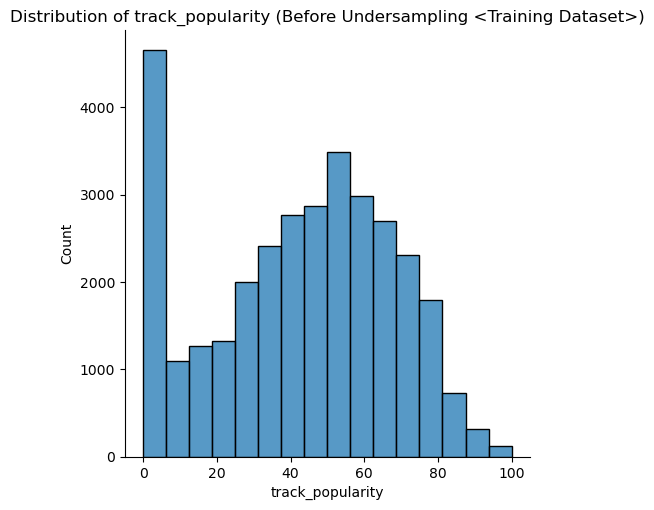

Showing Plot for After Undersampling


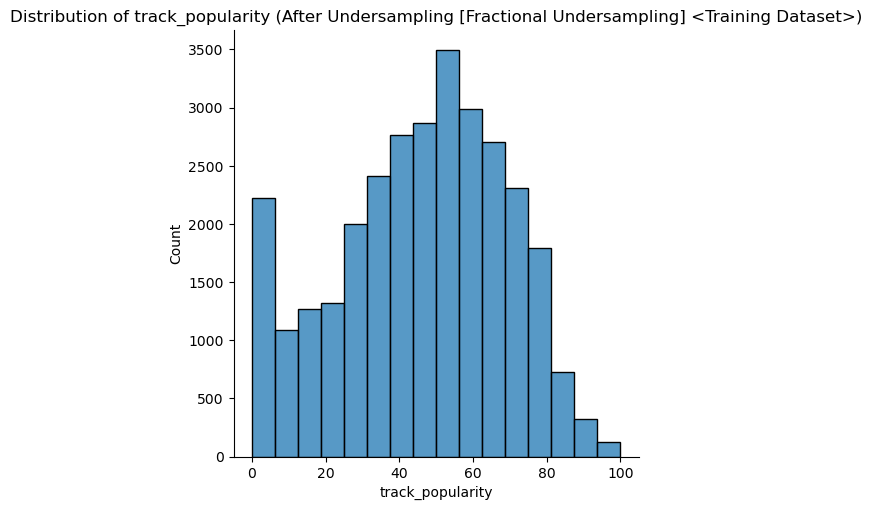

Showing Plot for Before Undersampling


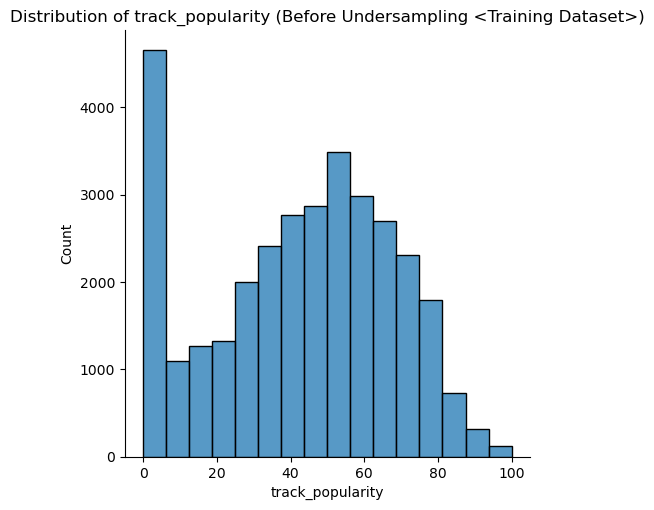

Showing Plot for After Undersampling


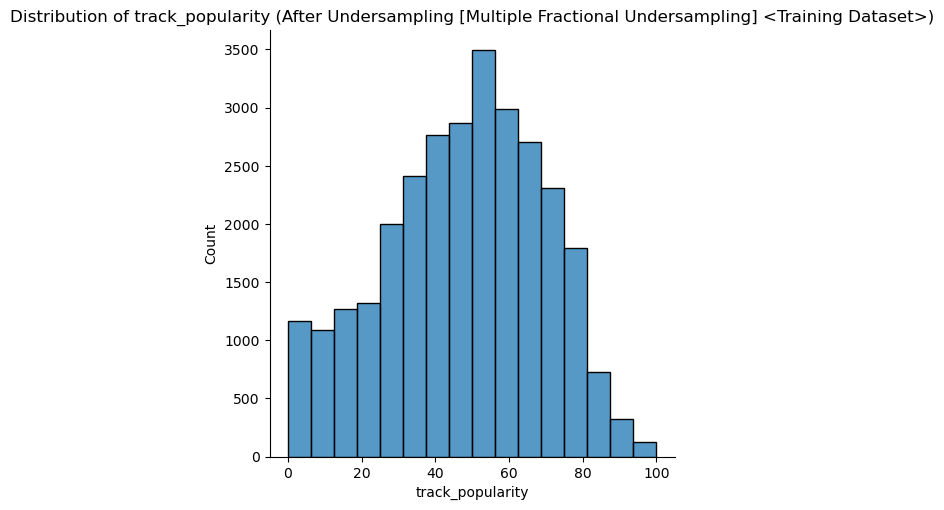

In [14]:
if (undersampling == "test"):
    trainDfTest = {
        "nu": trainDf,
        "su": undersample(trainDf, 'track_popularity', method = "singular", fraction = 0.1, bins = bins, title = "Training Dataset"),
        "mu": undersample(trainDf, 'track_popularity', method = "multiple", fraction = [0.1, 0.4], margin = [0, 5], bins = bins, title = "Training Dataset")
    }

##### Summary

In [15]:
if (undersampling == "test"):
    toConcat = list()
    for key in trainDfTest.keys():
        toConcat.append(trainDfTest[key].copy())
    summaryData = pd.concat(toConcat, keys = ["No Undersampling", "Multiple Undersampling", "Singular Undersampling"], names = ["Types"])

elif (undersampling == "none"):
    summaryData = trainDf.copy()
    
else:
    toConcat = [
        ogTrainDf,
        trainDf
    ]
    summaryData = pd.concat(toConcat, keys = ["Original Dataset", "Undersampled Dataset"], names = ["Types"])

summaryData

track_id  \
Types                                                  
No Undersampling       0      6f807x0ima9a1j3VPbc7VN   
                       1      0r7CVbZTWZgbTCYdfa2P31   
                       2      1z1Hg7Vb0AhHDiEmnDE79l   
                       3      75FpbthrwQmzHlBJLuGdC7   
                       4      1e8PAfcKUYoKkxPhrHqw4x   
...                                              ...   
Singular Undersampling 32828  7bxnKAamR3snQ1VGLuVfC1   
                       32829  5Aevni09Em4575077nkWHz   
                       32830  7ImMqPP3Q1yfUHvsdn7wEo   
                       32831  2m69mhnfQ1Oq6lGtXuYhgX   
                       32832  29zWqhca3zt5NsckZqDf6c   

                                                                     track_name  \
Types                                                                             
No Undersampling       0      I Don't Care (with Justin Bieber) - Loud Luxur...   
                       1                        Memories - Dillon Francis Remix   
                       2                        All the Time - Don Diablo Remix   
                       3                      Call You Mine - Keanu Silva Remix   
                       4                Someone You Loved - Future Humans Remix   
...                                                                         ...   
Singular Undersampling 32828               City Of Lights - Official Radio Edit   
                       32829                Closer - Sultan & Ned Shepard Remix   
                       32830                       Sweet Surrender - Radio Edit   
                       32831                     Only For You - Maor Levi Remix   
                       32832                             Typhoon - Original Mix   

                                  track_artist  track_popularity  \
Types                                                              
No Undersampling       0            Ed Sheeran                66   
                       1              Maroon 5                67   
                       2          Zara Larsson                70   
                       3      The Chainsmokers                60   
                       4         Lewis Capaldi                69   
...                                        ...               ...   
Singular Undersampling 32828      Lush & Simon                42   
                       32829    Tegan and Sara                20   
                       32830       Starkillers                14   
                       32831            Mat Zo                15   
                       32832      Julian Calor                27   

                                      track_album_id  \
Types                                                  
No Undersampling       0      2oCs0DGTsRO98Gh5ZSl2Cx   
                       1      63rPSO264uRjW1X5E6cWv6   
                       2      1HoSmj2eLcsrR0vE9gThr4   
                       3      1nqYsOef1yKKuGOVchbsk6   
                       4      7m7vv9wlQ4i0LFuJiE2zsQ   
...                                              ...   
Singular Undersampling 32828  2azRoBBWEEEYhqV6sb7JrT   
                       32829  6kD6KLxj7s8eCE3ABvAyf5   
                       32830  0ltWNSY9JgxoIZO4VzuCa6   
                       32831  1fGrOkHnHJcStl14zNx8Jy   
                       32832  0X3mUOm6MhxR7PzxG95rAo   

                                                               track_album_name  \
Types                                                                             
No Undersampling       0      I Don't Care (with Justin Bieber) [Loud Luxury...   
                       1                        Memories (Dillon Francis Remix)   
                       2                        All the Time (Don Diablo Remix)   
                       3                            Call You Mine - The Remixes   
                       4                Someone You Loved (Future Humans Remix)   
...                                     

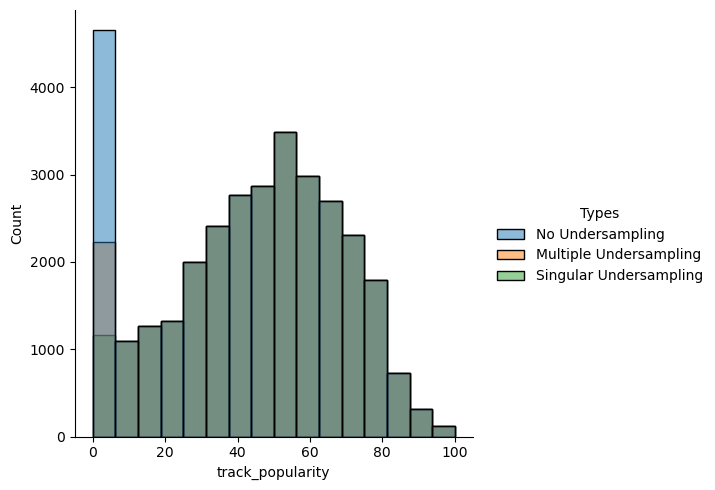

In [16]:
sns.displot(summaryData, x = 'track_popularity', bins = bins, hue = "Types")
# plt.title("Training Dataset Summary")

#### Remove Features

Removes all features that aren't in the `audioFeatures` list.

In [17]:
trainDf = trainDf[trainDf.columns.intersection(audioFeatures)]
trainDf.head(5)

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,66,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,67,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,70,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,60,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,69,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976


#### Triple M (Mean, Median, Mode) and Standard Deviation

In [18]:
print("No Undersampling:\n")
if undersampling == "test":
    preview = trainDfTest["nu"].describe().transpose()
else:
    preview = trainDf.describe().transpose()

preview

No Undersampling:



,count,mean,std,min,25%,50%,75%,max
track_popularity,32828.0,42.483551,24.980476,0.000000,24.00000,45.000000,62.00000,100.000
danceability,32828.0,0.654850,0.145092,0.000000,0.56300,0.672000,0.76100,0.983
energy,32828.0,0.698603,0.180916,0.000175,0.58100,0.721000,0.84000,1.000
key,32828.0,5.373949,3.611572,0.000000,2.00000,6.000000,9.00000,11.000
loudness,32828.0,-6.719529,2.988641,-46.448000,-8.17125,-6.166000,-4.64500,1.275
mode,32828.0,0.565737,0.495667,0.000000,0.00000,1.000000,1.00000,1.000
speechiness,32828.0,0.107053,0.101307,0.000000,0.04100,0.062500,0.13200,0.918
acousticness,32828.0,0.175352,0.219644,0.000000,0.01510,0.080400,0.25500,0.994
instrumentalness,32828.0,0.084760,0.224245,0.000000,0.00000,0.000016,0.00483,0.994
liveness,32828.0,0.190175,0.154313,0.000000,0.09270,0.127000,0.24800,0.996


In [19]:
print("Standard Undersampling:\n")
if undersampling == "test":
    preview = trainDfTest["su"].describe().transpose()
else:
    preview = None
preview

Standard Undersampling:



,count,mean,std,min,25%,50%,75%,max
track_popularity,30400.0,45.876645,22.763936,0.000000,31.000000,48.000000,63.00000,100.000
danceability,30400.0,0.655928,0.145137,0.077100,0.564000,0.673000,0.76200,0.983
energy,30400.0,0.694708,0.180879,0.000175,0.577000,0.717000,0.83600,1.000
key,30400.0,5.358750,3.615521,0.000000,2.000000,6.000000,9.00000,11.000
loudness,30400.0,-6.724625,2.983046,-46.448000,-8.167250,-6.174000,-4.65800,1.275
mode,30400.0,0.566316,0.495591,0.000000,0.000000,1.000000,1.00000,1.000
speechiness,30400.0,0.106922,0.101173,0.022400,0.040900,0.062400,0.13200,0.918
acousticness,30400.0,0.179236,0.221326,0.000001,0.016400,0.084400,0.26200,0.994
instrumentalness,30400.0,0.081040,0.219870,0.000000,0.000000,0.000014,0.00403,0.994
liveness,30400.0,0.188407,0.151830,0.009360,0.092775,0.126000,0.24500,0.996


In [20]:
print("Multiple Undersampling:\n")
if undersampling == "test":
    preview = trainDfTest["mu"].describe().transpose()
else:
    preview = None
preview

Multiple Undersampling:



,count,mean,std,min,25%,50%,75%,max
track_popularity,29342.0,47.440018,21.600510,0.000000,33.0000,49.000000,64.00000,100.000
danceability,29342.0,0.656330,0.145130,0.077100,0.5640,0.673000,0.76200,0.983
energy,29342.0,0.694030,0.181032,0.000175,0.5760,0.716000,0.83500,1.000
key,29342.0,5.352566,3.615372,0.000000,2.0000,6.000000,9.00000,11.000
loudness,29342.0,-6.724228,2.978441,-46.448000,-8.1610,-6.172000,-4.66400,1.275
mode,29342.0,0.566935,0.495508,0.000000,0.0000,1.000000,1.00000,1.000
speechiness,29342.0,0.106962,0.101064,0.022400,0.0410,0.062500,0.13200,0.918
acousticness,29342.0,0.179890,0.221796,0.000001,0.0164,0.085000,0.26300,0.992
instrumentalness,29342.0,0.080567,0.219217,0.000000,0.0000,0.000013,0.00387,0.994
liveness,29342.0,0.188618,0.152195,0.009360,0.0928,0.127000,0.24500,0.996


# Data Analytics

In [21]:
trainDf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
track_popularity,32828.0,42.483551,24.980476,0.000000,24.00000,45.000000,62.00000,100.000
danceability,32828.0,0.654850,0.145092,0.000000,0.56300,0.672000,0.76100,0.983
energy,32828.0,0.698603,0.180916,0.000175,0.58100,0.721000,0.84000,1.000
key,32828.0,5.373949,3.611572,0.000000,2.00000,6.000000,9.00000,11.000
loudness,32828.0,-6.719529,2.988641,-46.448000,-8.17125,-6.166000,-4.64500,1.275
mode,32828.0,0.565737,0.495667,0.000000,0.00000,1.000000,1.00000,1.000
speechiness,32828.0,0.107053,0.101307,0.000000,0.04100,0.062500,0.13200,0.918
acousticness,32828.0,0.175352,0.219644,0.000000,0.01510,0.080400,0.25500,0.994
instrumentalness,32828.0,0.084760,0.224245,0.000000,0.00000,0.000016,0.00483,0.994
liveness,32828.0,0.190175,0.154313,0.000000,0.09270,0.127000,0.24800,0.996


## Correlation

Check the correlation of each features.

### Data Frame Correlation Method

Using the `.corr()` function, visualize the correlation heatmap of each features.

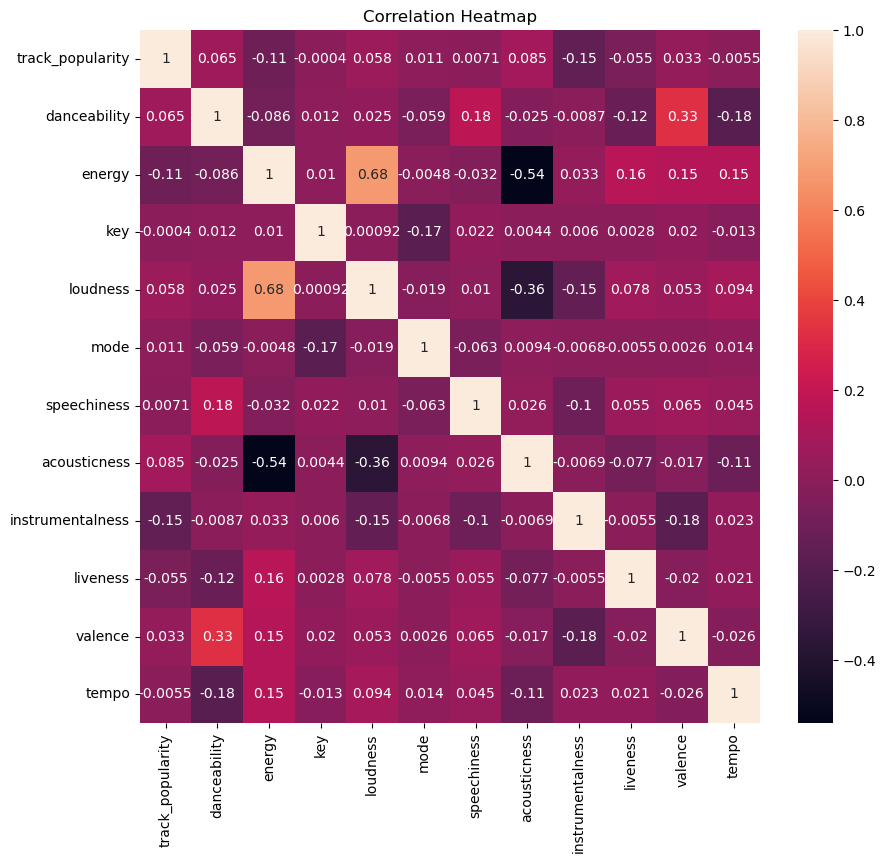

In [22]:
correlation = trainDf.corr()
plt.figure(figsize=(10,9))
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.show()

### Random Forest Correlation

Using a Random Forest Regressor, check and visualize the correlation of features against the `track_popularity` feature.

Random Forest Regressor Score: [0.26581647 0.26091712 0.22184695 0.25671951 0.26507301]
0.25 accuracy with a standard deviation of 0.02
8.668278851078878


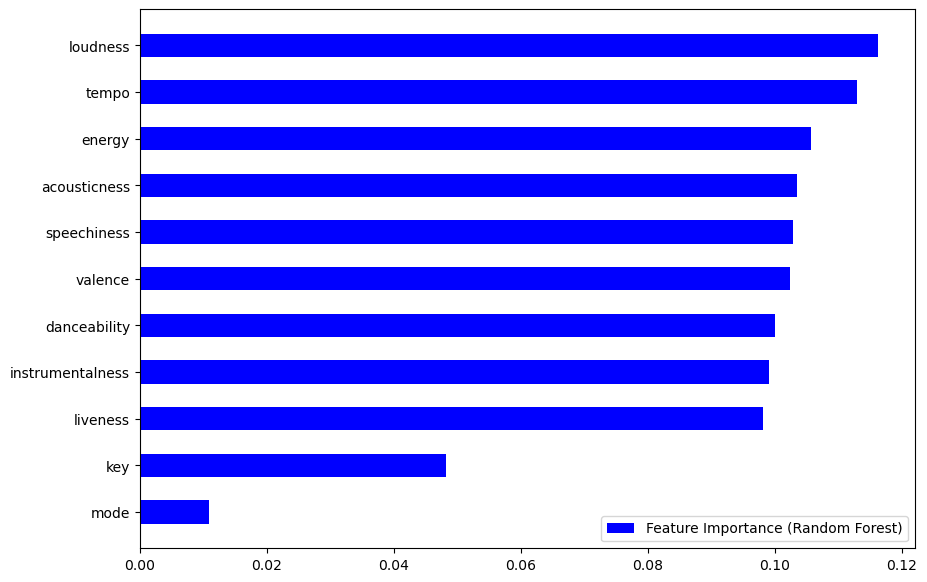

In [23]:
rfTrain, rfTest = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

featureFrameRF = selectFeatures(rfTrain['x'], rfTrain['y'], indexes, useRF = True)
featureFrameRF.sort_values(by = 'rfc', ascending = True, inplace = True)

indexRF = np.arange(len(featureFrameRF))
figRF, axRF = plt.subplots(figsize = (10, 7))
selectedFeaturesRF = axRF.barh(indexRF, featureFrameRF['rfc'], 0.5, color = 'blue', label = 'Feature Importance (Random Forest)')
axRF.set(yticks = indexRF, yticklabels = featureFrameRF.index)

axRF.legend()
plt.show()

### Decision Tree Correlation

Using a Decision Tree, check and visualize the correlation of features against the `track_popularity` feature.

Decision Tree Regressor Score: [-0.43542583 -0.47104223 -0.40727085 -0.38827079 -0.40423924]
-0.42 accuracy with a standard deviation of 0.03
4.22288904515968


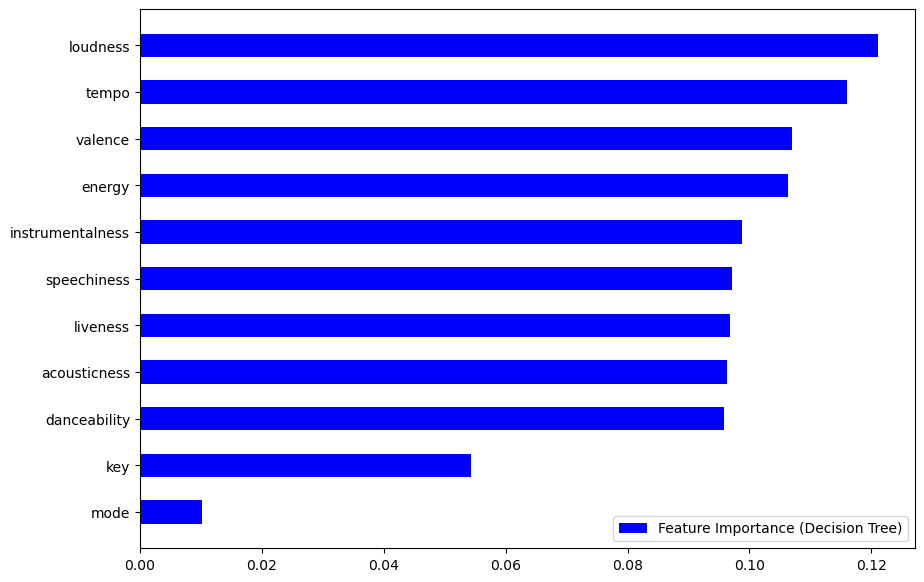

In [24]:
dtTrain, dtTest = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

featureFrameDT = selectFeatures(dtTrain['x'], dtTrain['y'], indexes, useRF = False)
featureFrameDT.sort_values(by = 'dt', ascending = True, inplace = True)

indexDT = np.arange(len(featureFrameDT))
figDT, axDT = plt.subplots(figsize = (10, 7))
selectedFeaturesDT = axDT.barh(indexDT, featureFrameDT['dt'], 0.5, color = 'blue', label = 'Feature Importance (Decision Tree)')
axDT.set(yticks = indexDT, yticklabels = featureFrameDT.index)

axDT.legend()
plt.show()

### Recursive Feature Elimination

Using an RFE, check the ranking of each feature to identify which features to use.

In [25]:
rfeTrain = dict()
rfeTest = dict()
featureFrameRFE = {
    "rf": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    },
    "dt": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    },
    "lr": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    }
}

# Random Forest Regressor
rfeTrain['rf'], rfeTest['rf'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())
# Decision Tree Regressor
rfeTrain['dt'], rfeTest['dt'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())
# Logistic Regression
rfeTrain['lr'], rfeTest['lr'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

#### Random Forest for RFE

Using Random Forest for RFE.

Support: [False  True False  True False  True  True False False False  True]

Ranking: [3 1 6 1 7 1 1 5 4 2 1]

RMSE Report:

8.819019024975896
RFE with Random Forest Regressor
{'mode': 7, 'key': 6, 'instrumentalness': 5, 'liveness': 4, 'danceability': 3, 'valence': 2, 'energy': 1, 'loudness': 1, 'speechiness': 1, 'acousticness': 1, 'tempo': 1}
{'energy': True, 'loudness': True, 'speechiness': True, 'acousticness': True, 'tempo': True, 'danceability': False, 'key': False, 'mode': False, 'instrumentalness': False, 'liveness': False, 'valence': False}


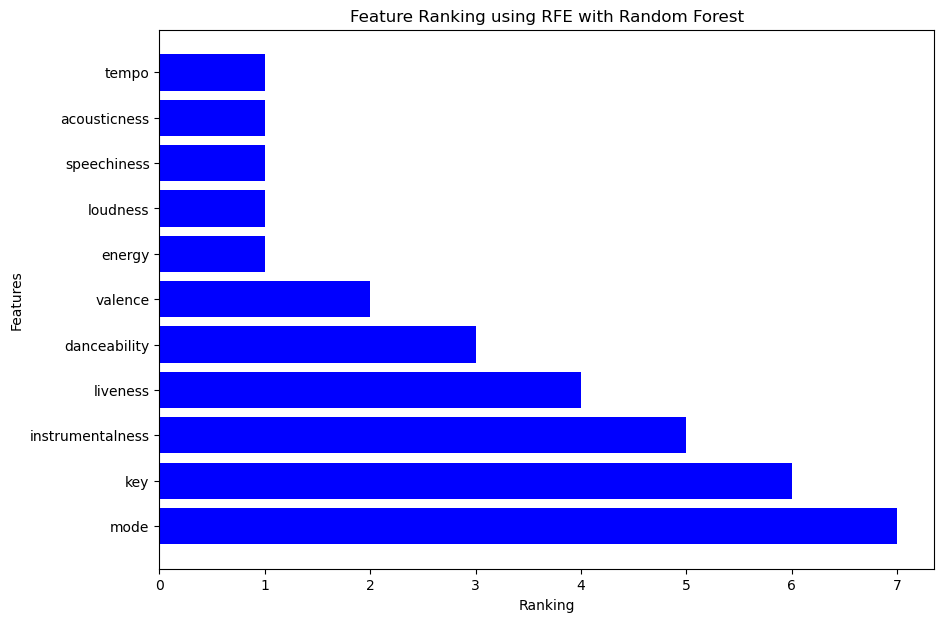

In [26]:
# Random Forests only
featureFrameRFE['rf']['support'], featureFrameRFE['rf']['ranking'] = selectFeaturesRFE(RandomForestRegressor(), rfeTrain['rf']['x'], rfeTrain['rf']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['rf']['ranking'])):
    featureFrameRFE['rf']['featureRanking'][indexes[i]] = int(featureFrameRFE['rf']['ranking'][i])
featureFrameRFE['rf']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['rf']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['rf']['support'])):
    featureFrameRFE['rf']['featureSupport'][indexes[i]] = bool(featureFrameRFE['rf']['support'][i])
featureFrameRFE['rf']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['rf']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Random Forest Regressor")
print(featureFrameRFE['rf']['featureRanking'])
print(featureFrameRFE['rf']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['rf']['featureRanking'])), featureFrameRFE['rf']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['rf']['featureRanking'])), featureFrameRFE['rf']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Random Forest')
plt.show()


#### Decision Tree for RFE

Using Decision Tree for RFE.

Support: [False  True False  True False  True  True False False False  True]

Ranking: [3 1 6 1 7 1 1 4 2 5 1]

RMSE Report:

4.163712852494104
RFE with Decision Tree Regressor
{'mode': 7, 'key': 6, 'valence': 5, 'instrumentalness': 4, 'danceability': 3, 'liveness': 2, 'energy': 1, 'loudness': 1, 'speechiness': 1, 'acousticness': 1, 'tempo': 1}
{'energy': True, 'loudness': True, 'speechiness': True, 'acousticness': True, 'tempo': True, 'danceability': False, 'key': False, 'mode': False, 'instrumentalness': False, 'liveness': False, 'valence': False}


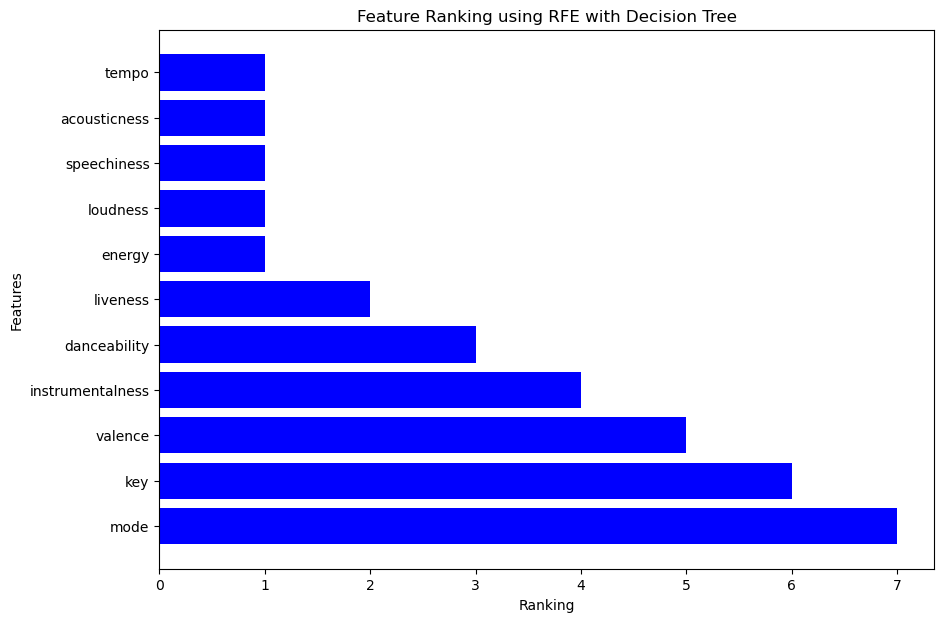

In [27]:
# Decision Tree only
featureFrameRFE['dt']['support'], featureFrameRFE['dt']['ranking'] = selectFeaturesRFE(DecisionTreeRegressor(), rfeTrain['dt']['x'], rfeTrain['dt']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['dt']['ranking'])):
    featureFrameRFE['dt']['featureRanking'][indexes[i]] = int(featureFrameRFE['dt']['ranking'][i])
featureFrameRFE['dt']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['dt']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['dt']['support'])):
    featureFrameRFE['dt']['featureSupport'][indexes[i]] = bool(featureFrameRFE['dt']['support'][i])
featureFrameRFE['dt']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['dt']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Decision Tree Regressor")
print(featureFrameRFE['dt']['featureRanking'])
print(featureFrameRFE['dt']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['dt']['featureRanking'])), featureFrameRFE['dt']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['dt']['featureRanking'])), featureFrameRFE['dt']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Decision Tree')
plt.show()


#### Logistic Regression for RFE

Using Logistic Regression for RFE.

Support: [False  True False  True  True False False  True  True False False]

Ranking: [3 1 4 1 1 2 5 1 1 6 7]

RMSE Report:

48.97935280289056
RFE with Logistic Regression
{'tempo': 7, 'valence': 6, 'acousticness': 5, 'key': 4, 'danceability': 3, 'speechiness': 2, 'energy': 1, 'loudness': 1, 'mode': 1, 'instrumentalness': 1, 'liveness': 1}
{'energy': True, 'loudness': True, 'mode': True, 'instrumentalness': True, 'liveness': True, 'danceability': False, 'key': False, 'speechiness': False, 'acousticness': False, 'valence': False, 'tempo': False}


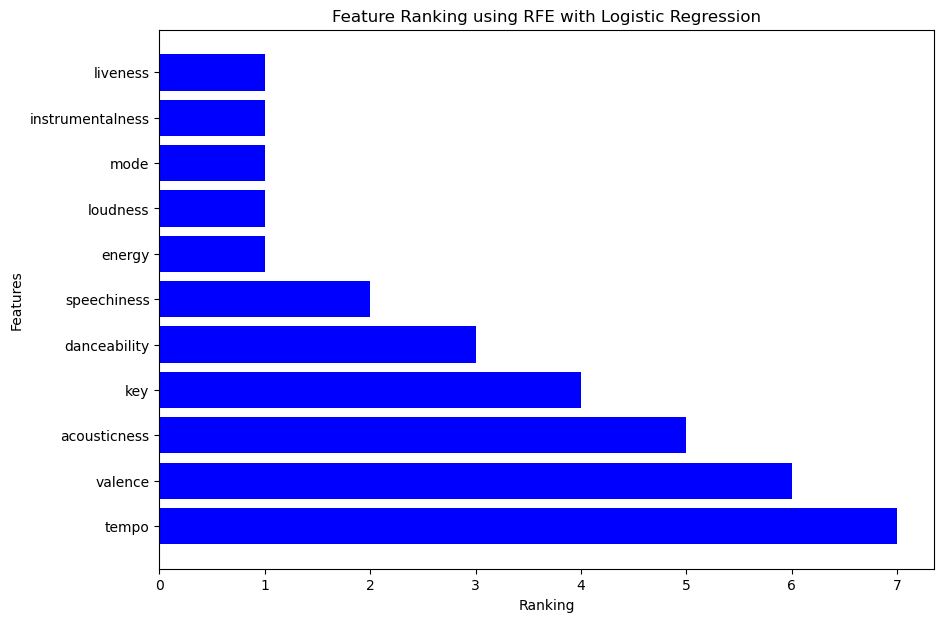

In [28]:
# Random Forests only
featureFrameRFE['lr']['support'], featureFrameRFE['lr']['ranking'] = selectFeaturesRFE(LogisticRegression(), rfeTrain['lr']['x'], rfeTrain['lr']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['lr']['ranking'])):
    featureFrameRFE['lr']['featureRanking'][indexes[i]] = int(featureFrameRFE['lr']['ranking'][i])
featureFrameRFE['lr']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['lr']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['lr']['support'])):
    featureFrameRFE['lr']['featureSupport'][indexes[i]] = bool(featureFrameRFE['lr']['support'][i])
featureFrameRFE['lr']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['lr']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Logistic Regression")
print(featureFrameRFE['lr']['featureRanking'])
print(featureFrameRFE['lr']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['lr']['featureRanking'])), featureFrameRFE['lr']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['lr']['featureRanking'])), featureFrameRFE['lr']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Logistic Regression')
plt.show()


## Comparison

Compare all results and see the most relevant features.

In [29]:
trainDfMod = trainDf.drop('track_popularity', axis = 1)
print(f"Original columns ({len(trainDfMod.columns)}):\n{trainDfMod.columns}")

Original columns (11):
Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')


In [30]:
# Random Forest Regressor
tdmRF = trainDfMod.loc[:,featureFrameRF['rfc'] > 0.1]
print(f"Random Forest Regressor ({len(tdmRF.columns)}):\n{tdmRF.columns}\n")

# Decision Tree Regressor
tdmDT = trainDfMod.loc[:,featureFrameDT['dt'] > 0.1]
print(f"Decision Tree Regressor ({len(tdmDT.columns)}):\n{tdmDT.columns}\n")

# Recursive Feature Elimination with Random Forest Regressor
tdmRFERFSup = trainDfMod.loc[:, featureFrameRFE['rf']['support']]
print(f"Recursive Feature Elimination [Random Forest - Support] ({len(tdmRFERFSup.columns)}):\n{tdmRFERFSup.columns}\n")

tdmRFERFRan = trainDfMod.loc[:, featureFrameRFE['rf']['ranking'] < 2]
print(f"Recursive Feature Elimination [Random Forest - Ranking] ({len(tdmRFERFRan.columns)}):\n{tdmRFERFRan.columns}\n")

# Recursive Feature Elimination with Decision Tree Regressor
tdmRFEDTSup = trainDfMod.loc[:, featureFrameRFE['dt']['support']]
print(f"Recursive Feature Elimination [Decision Tree - Support] ({len(tdmRFEDTSup.columns)}):\n{tdmRFEDTSup.columns}\n")

tdmRFEDTRan = trainDfMod.loc[:, featureFrameRFE['dt']['ranking'] < 2]
print(f"Recursive Feature Elimination [Decision Tree - Ranking] ({len(tdmRFEDTRan.columns)}):\n{tdmRFEDTRan.columns}\n")

# Recursive Feature Elimination with Logistic Regression
tdmRFELRSup = trainDfMod.loc[:, featureFrameRFE['lr']['support']]
print(f"Recursive Feature Elimination [Logistic Regression - Support] ({len(tdmRFELRSup.columns)}):\n{tdmRFELRSup.columns}\n")

tdmRFELRRan = trainDfMod.loc[:, featureFrameRFE['lr']['ranking'] < 2]
print(f"Recursive Feature Elimination [Logistic Regression - Ranking] ({len(tdmRFELRRan.columns)}):\n{tdmRFELRRan.columns}\n")

Random Forest Regressor (7):
Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo'],
      dtype='object')

Decision Tree Regressor (4):
Index(['energy', 'loudness', 'valence', 'tempo'], dtype='object')

Recursive Feature Elimination [Random Forest - Support] (5):
Index(['energy', 'loudness', 'speechiness', 'acousticness', 'tempo'], dtype='object')

Recursive Feature Elimination [Random Forest - Ranking] (5):
Index(['energy', 'loudness', 'speechiness', 'acousticness', 'tempo'], dtype='object')

Recursive Feature Elimination [Decision Tree - Support] (5):
Index(['energy', 'loudness', 'speechiness', 'acousticness', 'tempo'], dtype='object')

Recursive Feature Elimination [Decision Tree - Ranking] (5):
Index(['energy', 'loudness', 'speechiness', 'acousticness', 'tempo'], dtype='object')

Recursive Feature Elimination [Logistic Regression - Support] (5):
Index(['energy', 'loudness', 'mode', 'instrumentalness', 'liveness'], dtype='object')

Re

### Intersection

In [31]:
selectedFeaturesIntersection = intersection(
    tdmRF.columns,
    intersection(
        tdmDT.columns,
        intersection(
            tdmRFERFSup.columns,
            intersection(
                tdmRFERFRan.columns,
                intersection(
                    tdmRFEDTSup.columns,
                    intersection(
                        tdmRFEDTRan.columns,
                        intersection(
                            tdmRFELRSup.columns,
                            tdmRFELRRan.columns
                        )
                    )
                )
            )
        )
    )
)

selectedFeaturesIntersection

['energy', 'loudness']

### Frequency

In [32]:
selectedFeaturesFrequency = dict()
currentlySelectedFeatures = [tdmRF, tdmDT, tdmRFERFSup, tdmRFERFRan, tdmRFEDTSup, tdmRFEDTRan, tdmRFELRSup, tdmRFELRRan]

In [33]:
for features in currentlySelectedFeatures:
    for feature in features.columns:
        if feature in selectedFeaturesFrequency:
            selectedFeaturesFrequency[feature] += 1
        else:
            selectedFeaturesFrequency[feature] = 1

selectedFeaturesFrequency = {k: v for k, v in sorted(selectedFeaturesFrequency.items(), key = lambda item: item[1], reverse = True)}
selectedFeaturesFrequency

{'energy': 8,
 'loudness': 8,
 'tempo': 6,
 'speechiness': 5,
 'acousticness': 5,
 'valence': 2,
 'mode': 2,
 'instrumentalness': 2,
 'liveness': 2,
 'danceability': 1}

#### Frequency Bar Graph

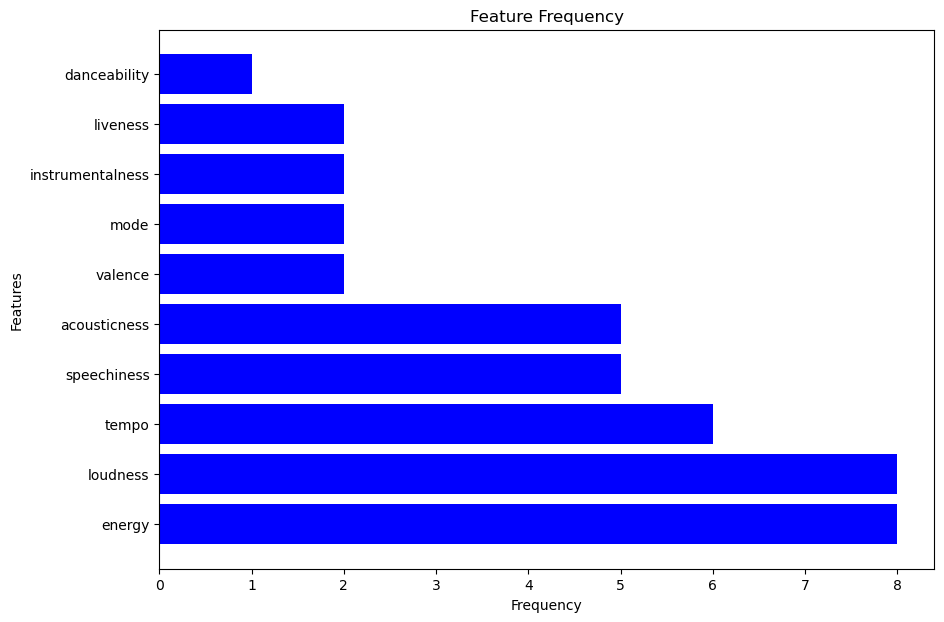

In [34]:
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(selectedFeaturesFrequency)), selectedFeaturesFrequency.values(), color='blue')
plt.yticks(np.arange(len(selectedFeaturesFrequency)), selectedFeaturesFrequency.keys())
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.title('Feature Frequency')
plt.show()

## Data Processing

Process data once more to only use the important features.

Intersection won't be used in this case due to a very low feature count.

In [35]:
# Get 70% of the total number of features
topFeatures = int(len(selectedFeaturesFrequency) * 0.75)
topFeatures

7

In [36]:
sffk = list(selectedFeaturesFrequency.keys())
sffk = sffk[:topFeatures]
sffk.append('track_popularity')
sffk

['energy',
 'loudness',
 'tempo',
 'speechiness',
 'acousticness',
 'valence',
 'mode',
 'track_popularity']

In [37]:
frequencyDf = None
if undersampling == "test":
    frequencyDf = dict()
    for key in trainDfTest:
        frequencyDf[key] = trainDfTest[key].loc[:, sffk]
        preview = frequencyDf[key].head(5)
else:
    frequencyDf = trainDf.loc[:, sffk]
    preview = frequencyDf.head(5)

preview

,energy,loudness,tempo,speechiness,acousticness,valence,mode,track_popularity
31477,0.663,-4.220,125.845,0.0836,0.1520,0.424,1,0
19974,0.795,-11.259,124.097,0.0461,0.0015,0.763,0,0
11132,0.499,-7.849,106.591,0.1140,0.4070,0.362,0,0
26734,0.418,-9.975,85.938,0.0310,0.7650,0.472,0,0
25490,0.338,-12.102,83.426,0.0736,0.4210,0.707,0,0


# Model Analytics

Check which model is the best to use in this scenario.

The following models are the one that are currently available for use:

- [Simple Linear Regression](#simple-linear-regression)
- [Logistic Regression](#logistic-regression)
- [Decision Tree](#decision-tree)
- [Random Forest](#random-forest)

## Model Training

In [38]:
folds = 10
testSize = 0.001

if undersampling == "test":
    modelTrainingData = dict()
    modelTestData = dict()
    for key in frequencyDf:
        print(f"Training {key} data")
        modelTrainingData[key], modelTestData[key] = splitData(frequencyDf[key], 'track_popularity', scaler = StandardScaler(), testSize = testSize)
else:
    modelTrainingData, modelTestData = splitData(frequencyDf, 'track_popularity', scaler = StandardScaler(), testSize = testSize)

Training nu data
Training su data
Training mu data


In [39]:
# TODO: Add a training model if testSize is 0
if (testSize == 0):
    pass

### Decision Tree

In [40]:
if undersampling == "test":
    modelDT = dict()
    for key in modelTrainingData:
        modelDT[key] = trainDecisionTree(modelTrainingData[key]["x"], modelTrainingData[key]["y"], folds = folds)
        yPredDT = modelDT[key].predict(modelTestData[key]["x"])
        print()
        
        # Mean Squared Error
        mseDT = root_mean_squared_error(modelTestData[key]["y"], yPredDT)
        print(f"Mean Squared Error ({key}): {mseDT:.2f}")
        
        # Accuracy Score
        accuracyScoreDT = modelDT[key].score(modelTestData[key]["x"], modelTestData[key]["y"])
        print(f"Accuracy Score ({key}): {accuracyScoreDT * 100:.2f}%")
        
        # Show Table of Predicted vs Actual Values
        pd.DataFrame({
            "Predicted": yPredDT,
            "Actual": modelTestData[key]["y"]
        })
else:
    modelDT = trainDecisionTree(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
    yPredDT = modelDT.predict(modelTestData["x"])
    print()

    # Mean Squared Error
    mseDT = root_mean_squared_error(modelTestData["y"], yPredDT)
    print(f"Mean Squared Error: {mseDT:.2f}")

    # Accuracy Score
    accuracyScoreDT = modelDT.score(modelTestData["x"], modelTestData["y"])
    print(f"Accuracy Score: {accuracyScoreDT * 100:.2f}%")

    # Show Table of Predicted vs Actual Values
    pd.DataFrame({
        "Predicted": yPredDT,
        "Actual": modelTestData["y"]
    })

Decision Tree Regressor Score: [-0.30875841 -0.28167109 -0.33590847 -0.34034853 -0.3228526  -0.36225271
 -0.32333032 -0.31670646 -0.39871473 -0.29348503]
-0.33 accuracy with a standard deviation of 0.03

Mean Squared Error (nu): 22.52
Accuracy Score (nu): 10.84%
Decision Tree Regressor Score: [-0.28846849 -0.3463804  -0.30120294 -0.31258013 -0.27381048 -0.41234832
 -0.34719515 -0.28462897 -0.30174943 -0.32062261]
-0.32 accuracy with a standard deviation of 0.04

Mean Squared Error (su): 31.10
Accuracy Score (su): -110.92%
Decision Tree Regressor Score: [-0.25596396 -0.26491626 -0.25090264 -0.32150211 -0.23882693 -0.2809155
 -0.25590627 -0.29992305 -0.33926155 -0.41461857]
-0.29 accuracy with a standard deviation of 0.05

Mean Squared Error (mu): 22.00
Accuracy Score (mu): -21.78%


### Random Forest

In [41]:
if undersampling == "test":
    modelRF = dict()
    for key in modelTrainingData:
        modelRF[key] = trainRandomForest(modelTrainingData[key]["x"], modelTrainingData[key]["y"], folds = folds)
        yPredRF = modelRF[key].predict(modelTestData[key]["x"])
        print()
        
        # Mean Squared Error
        mseRF = root_mean_squared_error(modelTestData[key]["y"], yPredRF)
        print(f"Mean Squared Error ({key}): {mseRF:.2f}")
        
        # Accuracy Score
        accuracyScoreRF = modelRF[key].score(modelTestData[key]["x"], modelTestData[key]["y"])
        print(f"Accuracy Score ({key}): {accuracyScoreRF * 100:.2f}%")
        
        # Show Table of Predicted vs Actual Values
        pd.DataFrame({
            "Predicted": yPredRF,
            "Actual": modelTestData[key]["y"]
        })
else:
    modelRF = trainRandomForest(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
    yPredRF = modelRF.predict(modelTestData["x"])
    print()

    # Mean Squared Error
    mseRF = root_mean_squared_error(modelTestData["y"], yPredRF)
    print(f"Mean Squared Error: {mseRF:.2f}")

    # Accuracy Score
    accuracyScoreRF = modelRF.score(modelTestData["x"], modelTestData["y"])
    print(f"Accuracy Score: {accuracyScoreRF * 100:.2f}%")

    # Show Table of Predicted vs Actual Values
    pd.DataFrame({
        "Predicted": yPredRF,
        "Actual": modelTestData["y"]
    })

Random Forest Regressor Score: [0.29956069 0.28759336 0.29457205 0.27828403 0.28643359 0.2538983
 0.29729933 0.2763935  0.2394413  0.30120263]
0.28 accuracy with a standard deviation of 0.02

Mean Squared Error (nu): 18.30
Accuracy Score (nu): 41.11%
Random Forest Regressor Score: [0.28129641 0.31160213 0.29445963 0.29122065 0.2846746  0.26479831
 0.27454046 0.29055383 0.2899101  0.27940783]
0.29 accuracy with a standard deviation of 0.01

Mean Squared Error (su): 22.05
Accuracy Score (su): -6.06%
Random Forest Regressor Score: [0.29504471 0.2989588  0.30905863 0.28852839 0.29140028 0.33163666
 0.3059481  0.31013764 0.32942084 0.26149314]
0.30 accuracy with a standard deviation of 0.02

Mean Squared Error (mu): 14.41
Accuracy Score (mu): 47.75%


# Prediction

Predict some data.

## Fetch Music

- Kekkon Koushinkyoku (ASOBI同盟)   - 09o4dR4x2Sx6wjv4u5xdux
- Night Dancer (imase)              - 3gmn76fCtpDazGMnN0QMHX
- Fallen (Lola Amour)               - 4mc3rUoMwwiNTHA4al9nNd

In [42]:
# All other songs goes here.
songIDs = [
    "3gmn76fCtpDazGMnN0QMHX",
    "4mc3rUoMwwiNTHA4al9nNd"
]

# Initial song goes here for variable initialization
songData = getSongData("09o4dR4x2Sx6wjv4u5xdux", True, True)
forPrediction = {
    "data": songData[0],
    "name": [songData[1]],
    "actual": [int(songData[0].iloc[0]['track_popularity'])]
}

dataLen = 1
for id in songIDs:
    songData = getSongData(id, True, True)
    songData[0].index = [dataLen]
    dataLen += 1
    forPrediction["data"] = pd.concat([forPrediction["data"], songData[0]])
    forPrediction["name"].append(songData[1])
    forPrediction["actual"].append(int(songData[0].iloc[0]['track_popularity']))
    # Sleep for 4 second to avoid rate limiting
    sleep(4)

forPrediction["data"] = forPrediction["data"].loc[:, sffk]
forPrediction["data"].drop('track_popularity', axis = 1, inplace = True)
forPrediction["scaled"] = {
    "standard": StandardScaler().fit_transform(forPrediction["data"]),
    "minMax": MinMaxScaler().fit_transform(forPrediction["data"])
}

nameActual = pd.DataFrame({"Song Name": forPrediction["name"], "Actual Scores": forPrediction["actual"]})
nameActual

<Response [429]>


Exception: getToken: Rate Limit Exceeded

In [ ]:
forPrediction["data"]

## Predict Data

Predict the data for the fetched music.

### Standard Scaler

In [ ]:
if undersampling != "test":
    yPredDT = modelDT.predict(forPrediction["scaled"]["standard"])
    yPredRF = modelRF.predict(forPrediction["scaled"]["standard"])

In [ ]:
if undersampling != "test":
    print(f"Accuracy Score for Decision Tree: {modelDT.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")
    print(f"Accuracy Score for Random Forest: {modelRF.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")

In [ ]:
if undersampling != "test":
    print(f"Mean Squared Error for Decision Tree: {root_mean_squared_error(forPrediction["actual"], yPredDT)}")
    print(f"Mean Squared Error for Random Forest: {root_mean_squared_error(forPrediction["actual"], yPredRF)}")

In [ ]:
preview = None
if undersampling != "test":
    preview = pd.DataFrame({
        "Decision Tree": yPredDT,
        "Random Forest": yPredRF,
        "Actual": forPrediction["actual"]
    })
preview

### MinMax Scaler

In [ ]:
if undersampling != "test":
    yPredDT = modelDT.predict(forPrediction["scaled"]["minMax"])
    yPredRF = modelRF.predict(forPrediction["scaled"]["minMax"])

In [ ]:
if undersampling != "test":
    print(f"Accuracy Score for Decision Tree: {modelDT.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")
    print(f"Accuracy Score for Random Forest: {modelRF.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")

In [ ]:
if undersampling != "test":
    print(f"Mean Squared Error for Decision Tree: {root_mean_squared_error(forPrediction["actual"], yPredDT)}")
    print(f"Mean Squared Error for Random Forest: {root_mean_squared_error(forPrediction["actual"], yPredRF)}")

In [ ]:
preview = None
if undersampling != "test":
    pd.DataFrame({
        "Decision Tree": yPredDT,
        "Random Forest": yPredRF,
        "Actual": forPrediction["actual"]
    })
preview

## More Prediction Test (I)

In [146]:
metrics = dict()
testDfs = dict()

### Import Test Data

In [147]:
# 114k Dataset
testData = importData(f"{dataPath}/custom-2/dataset.csv")

# 2k Dataset
# testData = importData(f"{dataPath}/saved/top-hits.csv")

### Cut Data

Limit the fetched data into just 1000 items to prevent rate limiting.

If the `amountToKeep` is similar to the rows of data, then just skip the cutting part.

In [148]:
# 250000 Items
amountToKeep = len(testData)

if (amountToKeep != len(testData)):
    testData = testData[:250000]

len(testData)

114000

### Extract IDs

Extract IDs as a single list then make them in chunks of 100 items per list.

In [149]:
trackIDs = []
if (not 'track_popularity' in list(testData.columns)) and (not 'popularity' in list(testData.columns)):
    trackIDs = list(chunkList(testData['id'], 100))
trackIDs

[]

In [150]:
trackIDChunks = []

if (len(trackIDs) > 0):
    for chunk in trackIDs:
        trackIDChunks.append(",".join(chunk))

print(len(trackIDChunks))
trackIDChunks

0


[]

### Insert Track Popularity

Insert the `track_popularity` column in chunks then use `sleep` function to prevent rate limiting. It could be changed into `1` second instead but it's risky.

In [151]:
if 'popularity' in list(testData.columns):
    testData['track_popularity'] = testData['popularity']
    testData.drop('popularity', axis = 1, inplace = True)

elif not 'track_popularity' in list(testData.columns):
    testData['track_popularity'] = int(0)
    for chunk in trackIDChunks:
        sleep(4)
        popularity = getPopularity(chunk, multiple = True)
        for itemID in popularity:
            testData.loc[testData['id'] == itemID, 'track_popularity'] = int(popularity[itemID])


testData.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,track_popularity
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,73
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,55
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,57
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,71
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,82


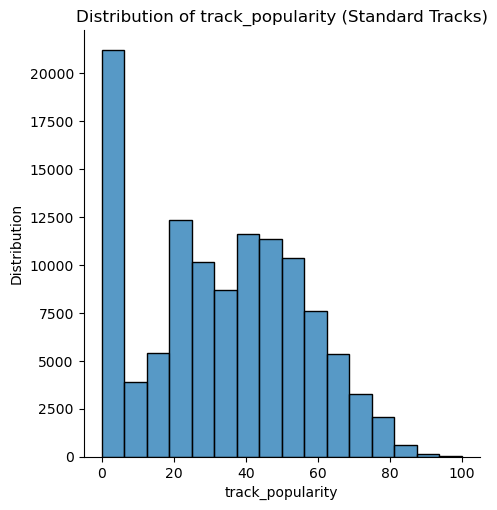

In [152]:
basicDisplot(testData, 'track_popularity', bins = bins, title = "Standard Tracks")

### Feature Engineering

In [153]:
testData = testData.loc[:, sffk]
testData.head(5)

,energy,loudness,tempo,speechiness,acousticness,valence,mode,track_popularity
0,0.4610,-6.746,87.917,0.1430,0.0322,0.715,0,73
1,0.1660,-17.235,77.489,0.0763,0.9240,0.267,1,55
2,0.3590,-9.734,76.332,0.0557,0.2100,0.120,1,57
3,0.0596,-18.515,181.740,0.0363,0.9050,0.143,1,71
4,0.4430,-9.681,119.949,0.0526,0.4690,0.167,1,82


Drop all rows with a `track_popularity` of `0`.

In [154]:
if dropZeroes:
    testData.drop(testData[testData.track_popularity == 0].index, inplace = True)

In [155]:
testDataDict = {
    "original": testData,
    "actual": testData['track_popularity'],
    "data": testData.drop('track_popularity', axis = 1),
}

testDataDict["data"] = StandardScaler().fit_transform(testDataDict["data"])
testDfs["Standard Tracks"] = testDataDict["original"]
testDataDict["data"].shape

(114000, 7)

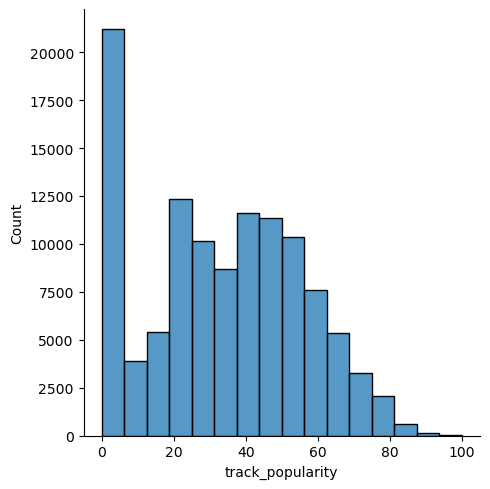

In [156]:
sns.displot(testDataDict["original"], x = 'track_popularity', bins = bins)

#### Checkpoint

Data could be save and loaded in here for other predictions, allowing faster run times and preventing the use of the API and other pre-processing stuff.

##### Save the data as CSV

Save the data as CSV to prevent repeated API request.

In [157]:
if saveInput:
    testDataDict["original"].to_csv(f"{dataPath}/saved/polished-data - {len(testDataDict["data"])}.csv", index = False)

##### Load the CSV

Load the CSV data here.

In [158]:
if saveInput:
    testDataDict["data"] = importData(f"{dataPath}/saved/polished-data - {len(testDataDict["data"])}.csv")

### Prediction

In [159]:
metrics[f"{len(testDataDict['data'])}"] = dict()
metrics

{'114000': {}}

In [160]:
if undersampling == "test":
    yPredDT = dict()
    yPredRF = dict()
    for key in trainDfTest:
        yPredDT[key] = modelDT[key].predict(testDataDict["data"])
        yPredRF[key] = modelRF[key].predict(testDataDict["data"])
else:
    yPredDT = modelDT.predict(testDataDict["data"])
    yPredRF = modelRF.predict(testDataDict["data"])

In [161]:
if undersampling == "test":
    rmse = dict()
    mse = dict()
    mae = dict()
    rs = dict()
    
    metrics[f"{len(testDataDict["data"])}"]["dt"] = dict()
    metrics[f"{len(testDataDict["data"])}"]["rf"] = dict()
    
    for key in trainDfTest:
        print(f"=========== {key} ===========")
        
        print(f"Accuracy Score for Decision Tree ({key}): {modelDT[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")
        print(f"Accuracy Score for Random Forest ({key}): {modelRF[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")

        print()
        
        rmse[key] = {
            "dt": root_mean_squared_error(testDataDict["actual"], yPredDT[key]),
            "rf": root_mean_squared_error(testDataDict["actual"], yPredRF[key])
        }

        mse[key] = {
            "dt": mean_squared_error(testDataDict["actual"], yPredDT[key]),
            "rf": mean_squared_error(testDataDict["actual"], yPredRF[key])
        }

        mae[key] = {
            "dt": mean_absolute_error(testDataDict["actual"], yPredDT[key]),
            "rf": mean_absolute_error(testDataDict["actual"], yPredRF[key])
        }

        print(f"Mean Squared Error for Decision Tree ({key}): {rmse[key]['dt']:.2f} (Raw: {mse[key]['dt']:.2f})")
        print(f"Mean Squared Error for Random Forest ({key}): {rmse[key]['rf']:.2f} (Raw: {mse[key]['rf']:.2f})")
        
        print(f"Mean Absolute Error for Decision Tree: {mae[key]["dt"]:.2f}")
        print(f"Mean Absolute Error for Random Forest: {mae[key]["rf"]:.2f}")
        print()

        metrics[f"{len(testDataDict["data"])}"]["dt"][key] = {
            "rmse": rmse[key]["dt"],
            "mse": mse[key]["dt"],
            "mae": mae[key]["dt"],
        }
        
        metrics[f"{len(testDataDict["data"])}"]["rf"][key] = {
            "rmse": rmse[key]["rf"],
            "mse": mse[key]["rf"],
            "mae": mae[key]["rf"],
        }
else:
    print(f"Accuracy Score for Decision Tree: {modelDT[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")
    print(f"Accuracy Score for Random Forest: {modelRF[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")

    print()

    rmse = {
        "dt": root_mean_squared_error(testDataDict["actual"], yPredDT),
        "rf": root_mean_squared_error(testDataDict["actual"], yPredRF)
    }

    mse = {
        "dt": mean_squared_error(testDataDict["actual"], yPredDT),
        "rf": mean_squared_error(testDataDict["actual"], yPredRF)
    }

    mae = {
        "dt": mean_absolute_error(testDataDict["actual"], yPredDT),
        "rf": mean_absolute_error(testDataDict["actual"], yPredRF)
    }

    metrics[f"{len(testDataDict["data"])}"]["dt"] = {
        "rmse": rmse[key]["dt"],
        "mse": mse[key]["dt"],
        "mae": mae[key]["dt"],
    }
    
    metrics[f"{len(testDataDict["data"])}"]["rf"] = {
        "rmse": rmse[key]["rf"],
        "mse": mse[key]["rf"],
        "mae": mae[key]["rf"],
    }

    print(f"Mean Squared Error for Decision Tree: {rmse["dt"]:.2f} (Raw: {mse["dt"]:.2f})")
    print(f"Mean Squared Error for Random Forest: {rmse["rf"]:.2f} (Raw: {mse["rf"]:.2f})")
    
    print(f"Mean Absolute Error for Decision Tree: {mae["dt"]:.2f}")
    print(f"Mean Absolute Error for Random Forest: {mae["rf"]:.2f}")

=========== nu ===========
Accuracy Score for Decision Tree (nu): -120.40%
Accuracy Score for Random Forest (nu): -18.67%

Mean Squared Error for Decision Tree (nu): 33.11 (Raw: 1096.51)
Mean Squared Error for Random Forest (nu): 24.30 (Raw: 590.41)
Mean Absolute Error for Decision Tree: 26.93
Mean Absolute Error for Random Forest: 19.72

=========== su ===========
Accuracy Score for Decision Tree (su): -114.34%
Accuracy Score for Random Forest (su): -29.19%

Mean Squared Error for Decision Tree (su): 32.66 (Raw: 1066.39)
Mean Squared Error for Random Forest (su): 25.35 (Raw: 642.71)
Mean Absolute Error for Decision Tree: 26.48
Mean Absolute Error for Random Forest: 20.52

=========== mu ===========
Accuracy Score for Decision Tree (mu): -108.67%
Accuracy Score for Random Forest (mu): -34.23%

Mean Squared Error for Decision Tree (mu): 32.22 (Raw: 1038.17)
Mean Squared Error for Random Forest (mu): 25.84 (Raw: 667.79)
Mean Absolute Error for Decision Tree: 26.11
Mean Absolute Error for

In [162]:
if undersampling == "test":
    popularityPrediction = {
        "Actual": testDataDict["actual"]
    }
    for key in trainDfTest.keys():
        popularityPrediction[(key, "Predicted (Decision Tree)")] = yPredDT[key]
        popularityPrediction[(key, "Predicted (Random Forest)")] = yPredRF[key]
    popularityPrediction = pd.DataFrame(popularityPrediction)
    # cols = pd.MultiIndex.from_product([["NU", "SU", "MU"], ["Predicted (Linear Regression)", "Predicted (Logistic Regression)", "Predicted (Decision Tree)", "Predicted (Random Forest)"]])
    # popularityPrediction = pd.DataFrame(popularityPrediction, index = testDataDict["actual"], columns = cols)
else:
    popularityPrediction = pd.DataFrame({
        "Actual": testDataDict["actual"],
        "Predicted (Decision Tree)": yPredDT,
        "Predicted (Random Forest)": yPredRF
    })

popularityPrediction

,Actual,"(nu, Predicted (Decision Tree))","(nu, Predicted (Random Forest))","(su, Predicted (Decision Tree))","(su, Predicted (Random Forest))","(mu, Predicted (Decision Tree))","(mu, Predicted (Random Forest))"
0,73,46.0,44.765000,18.0,43.140000,68.0,47.545000
1,55,12.0,43.200000,17.0,41.010000,44.0,44.060000
2,57,12.0,43.314571,42.8,45.366556,69.0,44.714095
3,71,64.0,43.888434,5.0,46.121667,36.0,48.993333
4,82,50.0,49.339000,59.0,50.060000,65.0,52.600000
...,...,...,...,...,...,...,...
113995,21,1.0,34.570000,68.0,39.805000,22.0,48.227500
113996,22,43.0,39.640000,56.0,46.170000,47.0,50.530000
113997,22,74.0,42.841667,65.0,46.372667,72.0,46.496000
113998,41,0.0,45.760000,48.0,43.460000,48.0,44.323333


In [163]:
if saveOutput:
    insertTxt = ""
    if undersampling == "test":
        insertTxt = " (With Undersampling and None)"
    print(f"{outputPath}/popularity-prediction{insertTxt} - {len(popularityPrediction)}.csv")
    popularityPrediction.to_csv(f"{outputPath}/popularity-prediction{insertTxt} - {len(popularityPrediction)}.csv", index = False)

./output/popularity-prediction (With Undersampling and None) - 114000.csv


## More Prediction Test (II)

### Import Test Data

In [164]:
# 114k Dataset
# testData = importData(f"{dataPath}/custom-2/dataset.csv")

# 2k Dataset
testData = importData(f"{dataPath}/saved/top-hits.csv")

### Cut Data

Limit the fetched data into just 1000 items to prevent rate limiting.

If the `amountToKeep` is similar to the rows of data, then just skip the cutting part.

In [165]:
# 250000 Items
amountToKeep = len(testData)

if (amountToKeep != len(testData)):
    testData = testData[:250000]

len(testData)

2000

### Extract IDs

Extract IDs as a single list then make them in chunks of 100 items per list.

In [166]:
trackIDs = []
if (not 'track_popularity' in list(testData.columns)) and (not 'popularity' in list(testData.columns)):
    trackIDs = list(chunkList(testData['id'], 100))
trackIDs

[]

In [167]:
trackIDChunks = []

if (len(trackIDs) > 0):
    for chunk in trackIDs:
        trackIDChunks.append(",".join(chunk))

print(len(trackIDChunks))
trackIDChunks

0


[]

### Insert Track Popularity

Insert the `track_popularity` column in chunks then use `sleep` function to prevent rate limiting. It could be changed into `1` second instead but it's risky.

In [168]:
if 'popularity' in list(testData.columns):
    testData['track_popularity'] = testData['popularity']
    testData.drop('popularity', axis = 1, inplace = True)

elif not 'track_popularity' in list(testData.columns):
    testData['track_popularity'] = int(0)
    for chunk in trackIDChunks:
        sleep(4)
        popularity = getPopularity(chunk, multiple = True)
        for itemID in popularity:
            testData.loc[testData['id'] == itemID, 'track_popularity'] = int(popularity[itemID])


testData.head(5)

,artist,song,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,track_popularity
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop,77
1,blink-182,All The Small Things,167066,False,1999,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop",79
2,Faith Hill,Breathe,250546,False,1999,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country",66
3,Bon Jovi,It's My Life,224493,False,2000,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal",78
4,*NSYNC,Bye Bye Bye,200560,False,2000,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop,65


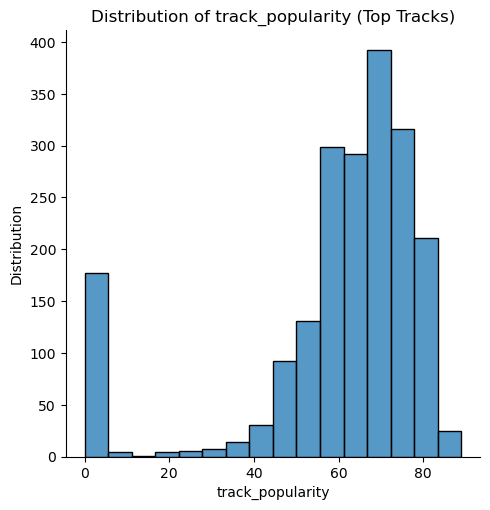

In [169]:
basicDisplot(testData, 'track_popularity', bins = bins, title = "Top Tracks")

### Feature Engineering

In [170]:
testData = testData.loc[:, sffk]
testData.head(5)

,energy,loudness,tempo,speechiness,acousticness,valence,mode,track_popularity
0,0.834,-5.444,95.053,0.0437,0.3000,0.894,0,77
1,0.897,-4.918,148.726,0.0488,0.0103,0.684,1,79
2,0.496,-9.007,136.859,0.0290,0.1730,0.278,1,66
3,0.913,-4.063,119.992,0.0466,0.0263,0.544,0,78
4,0.928,-4.806,172.656,0.0516,0.0408,0.879,0,65


Drop all rows with a `track_popularity` of `0`.

In [171]:
if dropZeroes:
    testData.drop(testData[testData.track_popularity == 0].index, inplace = True)

In [172]:
testDataDict = {
    "original": testData,
    "actual": testData['track_popularity'],
    "data": testData.drop('track_popularity', axis = 1),
}

testDataDict["data"] = StandardScaler().fit_transform(testDataDict["data"])
testDfs["Top Tracks"] = testDataDict["original"]
testDataDict["data"].shape

(2000, 7)

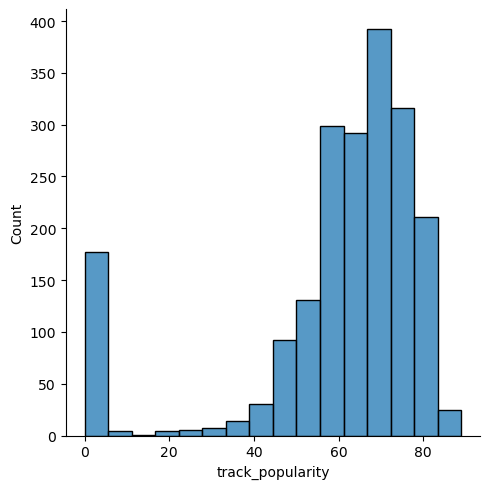

In [173]:
sns.displot(testDataDict["original"], x = 'track_popularity', bins = bins)

#### Checkpoint

Data could be save and loaded in here for other predictions, allowing faster run times and preventing the use of the API and other pre-processing stuff.

##### Save the data as CSV

Save the data as CSV to prevent repeated API request.

In [174]:
if saveInput:
    testDataDict["original"].to_csv(f"{dataPath}/saved/polished-data - {len(testDataDict["data"])}.csv", index = False)

##### Load the CSV

Load the CSV data here.

In [175]:
if saveInput:
    testDataDict["data"] = importData(f"{dataPath}/saved/polished-data - {len(testDataDict["data"])}.csv")

### Prediction

In [176]:
metrics[f"{len(testDataDict['data'])}"] = dict()
metrics

{'114000': {'dt': {'nu': {'rmse': np.float64(33.113562193945434),
    'mse': np.float64(1096.5080011722923),
    'mae': np.float64(26.93458774018379)},
   'su': {'rmse': np.float64(32.655555341916916),
    'mse': np.float64(1066.3852946889983),
    'mae': np.float64(26.48192664742665)},
   'mu': {'rmse': np.float64(32.22061945941442),
    'mse': np.float64(1038.1683183483954),
    'mae': np.float64(26.112297869674183)}},
  'rf': {'nu': {'rmse': np.float64(24.298417819587684),
    'mse': np.float64(590.4131085352564),
    'mae': np.float64(19.717471642618925)},
   'su': {'rmse': np.float64(25.35179983992835),
    'mse': np.float64(642.7137551237911),
    'mae': np.float64(20.518996440689648)},
   'mu': {'rmse': np.float64(25.841689178107156),
    'mse': np.float64(667.7928995779006),
    'mae': np.float64(20.861392739937482)}}},
 '2000': {}}

In [177]:
if undersampling == "test":
    yPredDT = dict()
    yPredRF = dict()
    for key in trainDfTest:
        yPredDT[key] = modelDT[key].predict(testDataDict["data"])
        yPredRF[key] = modelRF[key].predict(testDataDict["data"])
else:
    yPredDT = modelDT.predict(testDataDict["data"])
    yPredRF = modelRF.predict(testDataDict["data"])

In [178]:
if undersampling == "test":
    rmse = dict()
    mse = dict()
    mae = dict()
    rs = dict()
    
    metrics[f"{len(testDataDict["data"])}"]["dt"] = dict()
    metrics[f"{len(testDataDict["data"])}"]["rf"] = dict()
    
    for key in trainDfTest:
        print(f"=========== {key} ===========")
        
        print(f"Accuracy Score for Decision Tree ({key}): {modelDT[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")
        print(f"Accuracy Score for Random Forest ({key}): {modelRF[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")

        print()
        
        rmse[key] = {
            "dt": root_mean_squared_error(testDataDict["actual"], yPredDT[key]),
            "rf": root_mean_squared_error(testDataDict["actual"], yPredRF[key])
        }
        
        mse[key] = {
            "dt": mean_squared_error(testDataDict["actual"], yPredDT[key]),
            "rf": mean_squared_error(testDataDict["actual"], yPredRF[key])
        }
        
        mae[key] = {
            "dt": mean_absolute_error(testDataDict["actual"], yPredDT[key]),
            "rf": mean_absolute_error(testDataDict["actual"], yPredRF[key])
        }
        
        metrics[f"{len(testDataDict["data"])}"]["dt"][key] = {
            "rmse": rmse[key]["dt"],
            "mse": mse[key]["dt"],
            "mae": mae[key]["dt"],
        }
        
        metrics[f"{len(testDataDict["data"])}"]["rf"][key] = {
            "rmse": rmse[key]["rf"],
            "mse": mse[key]["rf"],
            "mae": mae[key]["rf"],
        }
        
        print(f"Mean Squared Error for Decision Tree ({key}): {rmse[key]['dt']:.2f} (Raw: {mse[key]['dt']:.2f})")
        print(f"Mean Squared Error for Random Forest ({key}): {rmse[key]['rf']:.2f} (Raw: {mse[key]['rf']:.2f})")
        
        print(f"Mean Absolute Error for Decision Tree: {mae[key]["dt"]:.2f}")
        print(f"Mean Absolute Error for Random Forest: {mae[key]["rf"]:.2f}")
        print()
else:
    print(f"Accuracy Score for Decision Tree: {modelDT[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")
    print(f"Accuracy Score for Random Forest: {modelRF[key].score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")

    print()

    rmse = {
        "dt": root_mean_squared_error(testDataDict["actual"], yPredDT),
        "rf": root_mean_squared_error(testDataDict["actual"], yPredRF)
    }

    mse = {
        "dt": mean_squared_error(testDataDict["actual"], yPredDT),
        "rf": mean_squared_error(testDataDict["actual"], yPredRF)
    }

    mae = {
        "dt": mean_absolute_error(testDataDict["actual"], yPredDT),
        "rf": mean_absolute_error(testDataDict["actual"], yPredRF)
    }

    metrics[f"{len(testDataDict["data"])}"]["dt"] = {
        "rmse": rmse[key]["dt"],
        "mse": mse[key]["dt"],
        "mae": mae[key]["dt"]
    }
    
    metrics[f"{len(testDataDict["data"])}"]["rf"] = {
        "rmse": rmse[key]["rf"],
        "mse": mse[key]["rf"],
        "mae": mae[key]["rf"]
    }

    print(f"Mean Squared Error for Decision Tree: {rmse["dt"]:.2f} (Raw: {mse["dt"]:.2f})")
    print(f"Mean Squared Error for Random Forest: {rmse["rf"]:.2f} (Raw: {mse["rf"]:.2f})")
    
    print(f"Mean Absolute Error for Decision Tree: {mae["dt"]:.2f}")
    print(f"Mean Absolute Error for Random Forest: {mae["rf"]:.2f}")

=========== nu ===========
Accuracy Score for Decision Tree (nu): -213.02%
Accuracy Score for Random Forest (nu): -84.22%

Mean Squared Error for Decision Tree (nu): 37.74 (Raw: 1424.16)
Mean Squared Error for Random Forest (nu): 28.95 (Raw: 838.17)
Mean Absolute Error for Decision Tree: 30.44
Mean Absolute Error for Random Forest: 26.52

=========== su ===========
Accuracy Score for Decision Tree (su): -171.07%
Accuracy Score for Random Forest (su): -59.66%

Mean Squared Error for Decision Tree (su): 35.12 (Raw: 1233.33)
Mean Squared Error for Random Forest (su): 26.95 (Raw: 726.40)
Mean Absolute Error for Decision Tree: 28.26
Mean Absolute Error for Random Forest: 24.12

=========== mu ===========
Accuracy Score for Decision Tree (mu): -149.06%
Accuracy Score for Random Forest (mu): -47.75%

Mean Squared Error for Decision Tree (mu): 33.66 (Raw: 1133.19)
Mean Squared Error for Random Forest (mu): 25.93 (Raw: 672.25)
Mean Absolute Error for Decision Tree: 27.24
Mean Absolute Error for

In [179]:
if undersampling == "test":
    popularityPrediction = {
        "Actual": testDataDict["actual"]
    }
    for key in trainDfTest.keys():
        popularityPrediction[(key, "Predicted (Decision Tree)")] = yPredDT[key]
        popularityPrediction[(key, "Predicted (Random Forest)")] = yPredRF[key]
    popularityPrediction = pd.DataFrame(popularityPrediction)
    # cols = pd.MultiIndex.from_product([["NU", "SU", "MU"], ["Predicted (Linear Regression)", "Predicted (Logistic Regression)", "Predicted (Decision Tree)", "Predicted (Random Forest)"]])
    # popularityPrediction = pd.DataFrame(popularityPrediction, index = testDataDict["actual"], columns = cols)
else:
    popularityPrediction = pd.DataFrame({
        "Actual": testDataDict["actual"],
        "Predicted (Decision Tree)": yPredDT,
        "Predicted (Random Forest)": yPredRF
    })

popularityPrediction

,Actual,"(nu, Predicted (Decision Tree))","(nu, Predicted (Random Forest))","(su, Predicted (Decision Tree))","(su, Predicted (Random Forest))","(mu, Predicted (Decision Tree))","(mu, Predicted (Random Forest))"
0,77,66.000000,48.930000,43.0,44.585000,38.0,51.780667
1,79,44.000000,40.727500,20.0,46.690833,64.0,45.100000
2,66,0.000000,51.250000,19.0,56.037500,65.0,53.810000
3,78,29.000000,38.864000,62.0,39.376667,29.0,40.250000
4,65,70.000000,40.765000,49.0,48.569048,62.0,50.217500
...,...,...,...,...,...,...,...
1995,79,28.000000,41.499000,44.0,41.920000,9.0,43.365000
1996,78,73.000000,38.981667,74.0,45.480000,25.0,44.115000
1997,69,64.000000,38.568333,33.0,41.780000,52.0,46.300000
1998,75,68.000000,45.060000,3.0,47.863333,65.0,47.300000


In [180]:
if saveOutput:
    insertTxt = ""
    if undersampling == "test":
        insertTxt = " (With Undersampling and None)"
    print(f"{outputPath}/popularity-prediction{insertTxt} - {len(popularityPrediction)}.csv")
    popularityPrediction.to_csv(f"{outputPath}/popularity-prediction{insertTxt} - {len(popularityPrediction)}.csv", index = False)

./output/popularity-prediction (With Undersampling and None) - 2000.csv


## Import Summary

In [181]:
keys = list(testDfs.keys())
toConcat = list()
for key in testDfs:
    toConcat.append(testDfs[key])

summaryData = pd.concat(toConcat, keys = keys, names = ["Test Data"])
summaryData

energy  loudness    tempo  speechiness  acousticness  \
Test Data                                                                    
Standard Tracks 0     0.4610    -6.746   87.917       0.1430        0.0322   
                1     0.1660   -17.235   77.489       0.0763        0.9240   
                2     0.3590    -9.734   76.332       0.0557        0.2100   
                3     0.0596   -18.515  181.740       0.0363        0.9050   
                4     0.4430    -9.681  119.949       0.0526        0.4690   
...                      ...       ...      ...          ...           ...   
Top Tracks      1995  0.7340    -5.065  137.958       0.0588        0.0427   
                1996  0.7020    -5.707  169.994       0.1570        0.1170   
                1997  0.6780    -8.635   97.984       0.1090        0.0669   
                1998  0.5200    -7.513  102.998       0.0656        0.4500   
                1999  0.7620    -3.497  120.042       0.0395        0.1920   

                      valence  mode  track_popularity  
Test Data                                              
Standard Tracks 0       0.715     0                73  
                1       0.267     1                55  
                2       0.120     1                57  
                3       0.143     1                71  
                4       0.167     1                82  
...                       ...   ...               ...  
Top Tracks      1995    0.952     0                79  
                1996    0.564     1                78  
                1997    0.811     1                69  
                1998    0.347     1                75  
                1999    0.553     1                85  

[116000 rows x 8 columns]

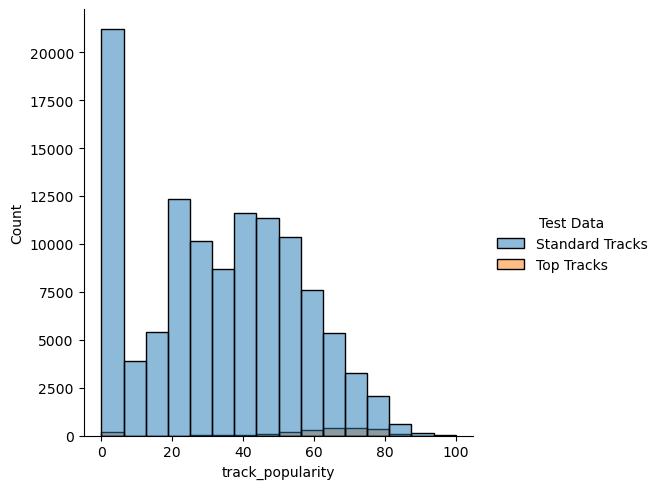

In [182]:
sns.displot(summaryData, x = "track_popularity", bins = bins, hue = "Test Data")
# plt.title("Test Dataset Summary")

# Metric Analysis

The models that will be used will be Decision Tree and Random Forest.

## Show Metrics

- [Root Mean Square Error (RMSE)](#root-mean-squared-error-rmse)
- [Mean Absolute Error (MAE)](#mean-absolute-error-mae)
- [R-Squared](#r-squared)

### Root Mean Squared Error (RMSE)

In [183]:
if undersampling == "test":
    print(
    f"""
    Root Mean Squared Error (RMSE):

    [No Undersampling]
    - Decision Tree: {rmse["nu"]["dt"]:.2f} - (Not Root: {mse["nu"]["dt"]:.2f})
    - Random Forest: {rmse["nu"]["rf"]:.2f} - (Not Root: {mse["nu"]["rf"]:.2f})

    [Singular Undersampling]
    - Decision Tree: {rmse["su"]["dt"]:.2f} - (Not Root: {mse["nu"]["dt"]:.2f})
    - Random Forest: {rmse["su"]["rf"]:.2f} - (Not Root: {mse["nu"]["rf"]:.2f})

    [Multiple Undersampling]
    - Decision Tree: {rmse["mu"]["dt"]:.2f} - (Not Root: {mse["nu"]["dt"]:.2f})
    - Random Forest: {rmse["mu"]["rf"]:.2f} - (Not Root: {mse["nu"]["rf"]:.2f})
    """)


    Root Mean Squared Error (RMSE):

    [No Undersampling]
    - Decision Tree: 37.74 - (Not Root: 1424.16)
    - Random Forest: 28.95 - (Not Root: 838.17)

    [Singular Undersampling]
    - Decision Tree: 35.12 - (Not Root: 1424.16)
    - Random Forest: 26.95 - (Not Root: 838.17)

    [Multiple Undersampling]
    - Decision Tree: 33.66 - (Not Root: 1424.16)
    - Random Forest: 25.93 - (Not Root: 838.17)
    


### Mean Absolute Error (MAE)

In [184]:
if undersampling == "test":
    print(
    f"""
    Mean Absolute Error (MAE):

    [No Undersampling]
    - Decision Tree: {mae["nu"]["dt"]:.2f})
    - Random Forest: {mae["nu"]["rf"]:.2f})

    [Singular Undersampling]
    - Decision Tree: {mae["su"]["dt"]:.2f})
    - Random Forest: {mae["su"]["rf"]:.2f})

    [Multiple Undersampling]
    - Decision Tree: {mae["mu"]["dt"]:.2f})
    - Random Forest: {mae["mu"]["rf"]:.2f})
    """)


    Mean Absolute Error (MAE):

    [No Undersampling]
    - Decision Tree: 30.44)
    - Random Forest: 26.52)

    [Singular Undersampling]
    - Decision Tree: 28.26)
    - Random Forest: 24.12)

    [Multiple Undersampling]
    - Decision Tree: 27.24)
    - Random Forest: 22.83)
    


### Summary

In [185]:
multiIndex = pd.MultiIndex.from_product([["Decision Tree", "Random Forest"], ["No Undersampling", "Multiple Undersampling", "Standard Undersampling"], ["RMSE", "MSE", "MAE"]])
metricsDf = pd.DataFrame(dict(), index = metrics.keys(), columns = multiIndex)

for amt in metrics.keys():
    for model in metrics[amt].keys():
        for underSampling in metrics[amt][model].keys():
            # print(f"{amt} - {model} - {underSampling}: {metrics[amt][model][underSampling]}")
            for metric in metrics[amt][model][underSampling].keys():
                # print(f"{amt} - {model} - {underSampling} - {metric}")
                modelStr = "Decision Tree" if model == "dt" else "Random Forest"
                underSamplingStr = "No Undersampling" if underSampling == "nu" else "Standard Undersampling" if underSampling == "su" else "Multiple Undersampling"
                metricStr = "RMSE" if metric == "rmse" else "MSE" if metric == "mse" else "MAE"
                metricsDf.loc[amt, (modelStr, underSamplingStr, metricStr)] = metrics[amt][model][underSampling][metric]

metricsDf

Decision Tree                                                 \
       No Undersampling                         Multiple Undersampling   
                   RMSE          MSE        MAE                   RMSE   
114000        33.113562  1096.508001  26.934588              32.220619   
2000          37.738101  1424.164238  30.443996              33.662941   

                                                                               \
                               Standard Undersampling                           
                MSE        MAE                   RMSE          MSE        MAE   
114000  1038.168318  26.112298              32.655555  1066.385295  26.481927   
2000    1133.193617  27.237634              35.118849  1233.333562  28.263658   

          Random Forest                                                \
       No Undersampling                        Multiple Undersampling   
                   RMSE         MSE        MAE                   RMSE   
114000        24.298418  590.413109  19.717472              25.841689   
2000          28.951141  838.168557  26.523879              25.927769   

                                                                             
                              Standard Undersampling                         
               MSE        MAE                   RMSE         MSE        MAE  
114000    667.7929  20.861393                25.3518  642.713755  20.518996  
2000    672.249193  22.829254              26.951802  726.399605  24.124597